## Loan Lending Club

### Supervised Learning: Classification Algorithms

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, 
    precision_recall_curve, auc, f1_score, accuracy_score,
    precision_score, recall_score, roc_auc_score, make_scorer,
    precision_recall_curve, confusion_matrix
)
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.exceptions import ConvergenceWarning

from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

##reco models - Logistic Regression (Baseline), 
# Random Forest (Handles non-linearity)
# XGBoost (Best for tabular data)
# Neural Networks (Only if dataset is massive)

#drop hardship + settlement

### **I. Data Preparation**
#### a. Load the dataset “Loan_Lending_Club.csv” and conduct an initial exploration of the data.

In [4]:
#Load the dataset
df = pd.read_csv('Loan_Lending_Club.csv', low_memory=False)

columns_to_drop = [
    #Metadata and ID features
    'Unnamed: 0', 'id', 'zip_code', 'title', 'addr_state',
    
    #Joint application features
    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 
    'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 
    'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 
    'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 
    'sec_app_collections_12_mths_ex_med',
    
    #Post-outcome features
    'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_pymnt_d',
    'total_rec_prncp', 'total_rec_int', 'total_pymnt', 'total_pymnt_inv',
    'last_fico_range_low', 'last_fico_range_high',
    'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
    'next_pymnt_d', 'months_since_last_pymnt_d',
    
    #Hardship and settlement features
    'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
    'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
    'hardship_length', 'hardship_dpd', 'hardship_loan_status', 
    'debt_settlement_flag', 'debt_settlement_flag_date',
    'settlement_status', 'settlement_date', 'settlement_amount', 
    'settlement_term', 'settlement_percentage'
]

#Use chunks to process file given large dataset
chunk_size = 200000 
sample_size = 0.05  
closed_loan_chunks = []

df = pd.read_csv('Loan_Lending_Club.csv', chunksize=chunk_size, low_memory=False)
for chunk in df:
    chunk_filtered = chunk.drop(columns=[col for col in columns_to_drop if col in chunk.columns])

    #Only include closed loans
    closed_loans_initial = chunk_filtered['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])
    closed_loans = chunk_filtered.loc[closed_loans_initial].copy()
    
    closed_loans.loc[:, 'loan_outcome'] = np.where(closed_loans['loan_status'].isin(['Charged Off', 'Default']),
                                                   1,  # Bad loans
                                                   0   # Good loans
                                                   )
    
    #Sample within the chunks
    if len(closed_loans) > 0:
        chunk_sample = closed_loans.sample(frac=sample_size, random_state=42)
        closed_loan_chunks.append(chunk_sample)

# Combine all sampled chunks
df_filtered = pd.concat(closed_loan_chunks)
df_filtered.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,deferral_term,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,loan_outcome
2988,5000.0,5000.0,5000.0,36 months,10.42%,162.33,B,B3,Certified Medical Assistant,4 years,...,0.0,49712.0,21954.0,18100.0,23412.0,NaN,NaN,NaN,NaN,0
173904,10000.0,10000.0,10000.0,36 months,18.06%,361.83,D,D2,Data Entry,< 1 year,...,0.0,35860.0,14119.0,21200.0,11860.0,NaN,NaN,NaN,NaN,0
106323,2750.0,2750.0,2750.0,36 months,9.93%,88.65,B,B2,System Engineer,3 years,...,0.0,33600.0,25647.0,7300.0,26000.0,NaN,NaN,NaN,NaN,0
169411,6500.0,6500.0,6500.0,36 months,9.93%,209.53,B,B2,Attorney,2 years,...,0.0,488212.0,296255.0,8600.0,264112.0,NaN,NaN,NaN,NaN,0
176787,3000.0,3000.0,3000.0,36 months,6.72%,92.25,A,A3,Project Manager,1 year,...,0.0,427644.0,50771.0,25600.0,47844.0,NaN,NaN,NaN,NaN,0


In [5]:
#Explore the dataset
print(f'Dataset Shape: {df_filtered.shape}')
print('\nSummary of the Data Set:')
df_filtered.info()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)   
pd.set_option('display.expand_frame_repr', False) 

print(f'\nSummary Statistics for Numerical Columns: \n {df_filtered.describe()}')
print(f"\nClass distribution: \n {df_filtered['loan_outcome'].value_counts()}")


Dataset Shape: (77654, 97)

Summary of the Data Set:
<class 'pandas.core.frame.DataFrame'>
Index: 77654 entries, 2988 to 2028284
Data columns (total 97 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   loan_amnt                                   77654 non-null  float64
 1   funded_amnt                                 77654 non-null  float64
 2   funded_amnt_inv                             77654 non-null  float64
 3   term                                        77654 non-null  object 
 4   int_rate                                    77654 non-null  object 
 5   installment                                 77654 non-null  float64
 6   grade                                       77654 non-null  object 
 7   sub_grade                                   77654 non-null  object 
 8   emp_title                                   72236 non-null  object 
 9   emp_length                    

Columns with missing values:                                         Column  Percent_Missing
92                               deferral_term        99.254385
93  orig_projected_additional_accrued_interest        98.990393
95                hardship_last_payment_amount        98.819121
94              hardship_payoff_balance_amount        98.819121
25                      mths_since_last_record        81.999639
67                    mths_since_recent_bc_dlq        75.499008
34                 mths_since_last_major_derog        71.832745
69              mths_since_recent_revol_delinq        65.297345
24                      mths_since_last_delinq        49.238932
46                                     il_util        48.261519
44                          mths_since_rcnt_il        41.508486
50                                    all_util        39.751977
43                                 open_il_24m        39.745538
45                                total_bal_il        39.745538
42         

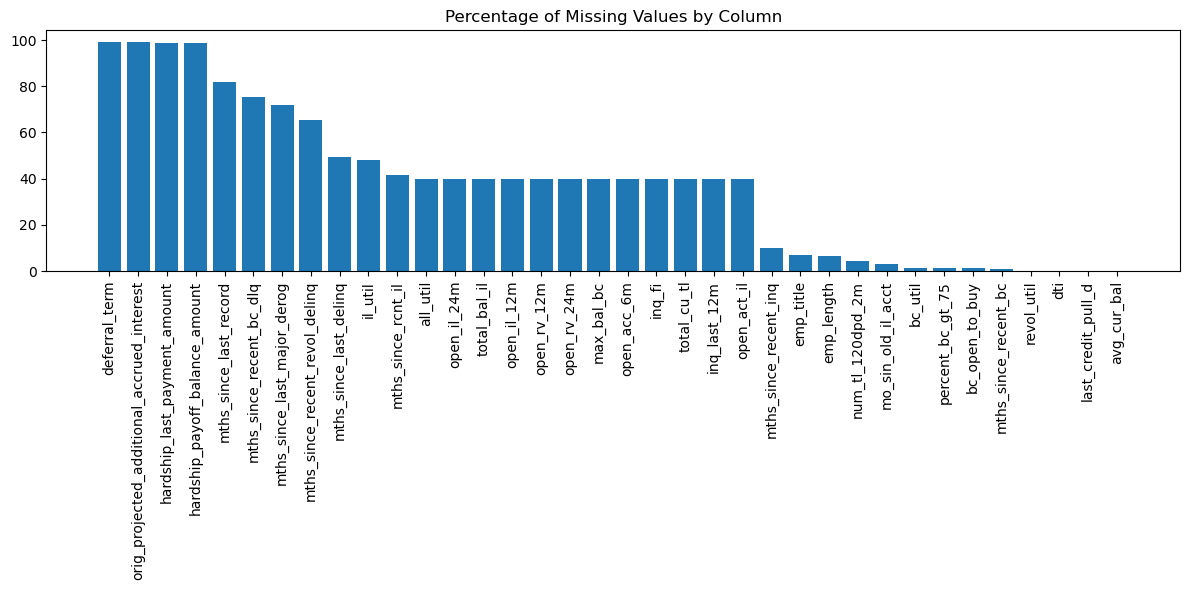

In [6]:
#Check which columns have missing values and how much
missing_percentages = (df_filtered.isnull().sum() / len(df_filtered)) * 100
missing_info = pd.DataFrame({
    'Column': missing_percentages.index,
    'Percent_Missing': missing_percentages.values
})
missing_info = missing_info[missing_info['Percent_Missing'] > 0].sort_values('Percent_Missing', ascending=False)

print(f'Columns with missing values: {missing_info}')

plt.figure(figsize=(12, 6))
plt.bar(missing_info['Column'], missing_info['Percent_Missing'])
plt.xticks(rotation=90)
plt.title('Percentage of Missing Values by Column')
plt.tight_layout()
plt.show()

#### b. Split dataset into training and testing sets

In [7]:
X = df_filtered.drop(['loan_outcome', 'loan_status'], axis=1)
y = df_filtered['loan_outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')
print(f'Class distribution in training set: \n{y_train.value_counts(normalize=True)}')
print(f'Class distribution in test set: \n{y_test.value_counts(normalize=True)}')

Training set shape: (62123, 95)
Test set shape: (15531, 95)
Class distribution in training set: 
loan_outcome
0    0.799044
1    0.200956
Name: proportion, dtype: float64
Class distribution in test set: 
loan_outcome
0    0.799047
1    0.200953
Name: proportion, dtype: float64


#### c. Handle missing values in categorical variables and determine which categorical variables to include in the model based on their predictive value

In [8]:
#1. Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop(['loan_status']) if 'loan_status' in categorical_cols else categorical_cols

#2. Remove unnecessary features (eg. too many unique values or statistically insignificant) and handle missing values
feature_analysis = {}
cols_to_drop = []

for col in categorical_cols:
    #Check for missing values
    missing_ratio = X_train[col].isnull().sum() / len(X_train)
    
    #Check if features are too unique
    n_unique = X_train[col].nunique()
    n_total = len(X_train)
    uniqueness_ratio = n_unique / n_total
    
    feature_analysis[col] = {
        'n_unique': n_unique,
        'uniqueness_ratio': uniqueness_ratio,
        'missing_ratio': missing_ratio
    }

    if uniqueness_ratio > 0.1:
        cols_to_drop.append((col, 'high_uniqueness'))
        continue

    #Do chi-square test to check for columns' statistical significance
    contingency_table = pd.crosstab(
        X_train[col].fillna('Missing'),
        y_train
    )
        
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    feature_analysis[col].update({
        'chi2_stat': chi2_stat,
        'p_value': p_value
    })
        
    if p_value >= 0.05: #Usual stat threshold for p-value significance
        cols_to_drop.append((col, 'insignificant'))

print('Feature Selection Analysis:')
print('\nColumns to drop:')
for col, reason in cols_to_drop:
    info = feature_analysis[col]
    if reason == 'high_uniqueness':
        print(f'- {col}: {info["n_unique"]} unique values ({info["uniqueness_ratio"]:.2%}) - Too many unique values')
    elif reason == 'insignificant':
        print(f'- {col}: p-value = {info["p_value"]:.3f} - Not statistically significant')

remaining_cols = [col for col in categorical_cols if col not in [c for c, _ in cols_to_drop]]

print(f'\nRemaining categorical features ({len(remaining_cols)}):')
for col in remaining_cols:
    if 'p_value' in feature_analysis[col]:
        print(f'- {col}: p-value = {feature_analysis[col]["p_value"]:.3f}')

#Drop columns
cols_to_drop = [col for col, _ in cols_to_drop]
X_train_cleaned = X_train.drop(columns=cols_to_drop)
X_test_cleaned = X_test.drop(columns=cols_to_drop)

#Print summary statistics
print(f'\nSummary of categorical columns:')
print(f'Original categorical columns: {len(categorical_cols)}')
print(f'Columns dropped: {len(cols_to_drop)}')
print(f'Remaining columns: {len(remaining_cols)}')

Feature Selection Analysis:

Columns to drop:
- emp_title: 25066 unique values (40.35%) - Too many unique values
- pymnt_plan: p-value = 1.000 - Not statistically significant
- url: 62123 unique values (100.00%) - Too many unique values
- initial_list_status: p-value = 0.720 - Not statistically significant

Remaining categorical features (13):
- term: p-value = 0.000
- int_rate: p-value = 0.000
- grade: p-value = 0.000
- sub_grade: p-value = 0.000
- emp_length: p-value = 0.000
- home_ownership: p-value = 0.000
- verification_status: p-value = 0.000
- issue_d: p-value = 0.000
- purpose: p-value = 0.000
- earliest_cr_line: p-value = 0.000
- revol_util: p-value = 0.008
- last_credit_pull_d: p-value = 0.000
- application_type: p-value = 0.000

Summary of categorical columns:
Original categorical columns: 17
Columns dropped: 4
Remaining columns: 13


##### d. Encode categorical features and convert to numerical, preprocess date columns to improve predictive modeling



In [9]:
def transform_features(df):
    """
    Transform features in the dataset
    """
    df = df.copy()

    #1. Term: Extract numerical values and remove "months"
    if 'term' in df.columns and df['term'].dtype == 'object':
        df['term'] = df['term'].str.extract(r'(\d+)').astype('float32')

    #2. Int_rate and revol_util: Remove percentage signs
    if 'int_rate' in df.columns and df['int_rate'].dtype == 'object':
        df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float32')
    if 'revol_util' in df.columns and df['revol_util'].dtype == 'object':
        df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float32')

    #3. Grade: Ordinal encoding
    if 'grade' in df.columns:
        grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
        df['grade'] = df['grade'].map(grade_map).astype('int8')

    #4. Subgrade: Ordinal encoding
    if 'sub_grade' in df.columns:
        df['sub_grade'] = df['sub_grade'].apply(lambda x: 
            np.nan if pd.isna(x) else (ord(x[0]) - ord('A')) * 5 + int(x[1])
        ).astype('int8')

    #5. Employment Length: Ordinal encoding
    if 'emp_length' in df.columns and df['emp_length'].dtype == 'object':
        df['emp_length'] = (df['emp_length']
            .replace({'< 1 year': '0 years', '10+ years': '10 years'})
            .str.extract(r'(\d+)')
            .astype('float32'))

    #6. Dates: Process date columns
    if 'issue_d' in df.columns:
        df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
        
        # Extract year and month features
        df['issue_year'] = df['issue_d'].dt.year
        df['issue_month'] = df['issue_d'].dt.month
        
        # Create cyclical month features
        months = df['issue_month'].values
        df['issue_month_sin'] = np.sin(2 * np.pi * months/12)
        df['issue_month_cos'] = np.cos(2 * np.pi * months/12)
    
        # Handle other date columns
        date_cols = [col for col in ['earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'] 
                    if col in df.columns]
        
        for col in date_cols:
            # Convert to datetime
            df[col] = pd.to_datetime(df[col], format='%b-%Y', errors='coerce')
            
            # Calculate months since
            if not pd.isna(df['issue_d']).all() and not pd.isna(df[col]).all():
                df[f'months_since_{col}'] = ((df['issue_d'].dt.year - df[col].dt.year) * 12 +
                          (df['issue_d'].dt.month - df[col].dt.month)).clip(lower=0).astype('float32')
                          
        # Drop the original date columns
        cols_to_drop = ['issue_d'] + date_cols
        df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

X_train_transformed = transform_features(X_train_cleaned)
X_test_transformed = transform_features(X_test_cleaned)

In [10]:
#Handle categorical features with OHE
categorical_cols = [col for col in [
    'home_ownership',     
    'verification_status',
    'purpose',          
    'application_type'  
] if col in X_train_transformed.columns]

if categorical_cols:
    cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_encoder.fit(X_train_transformed[categorical_cols])
    
    train_cat_encoded = cat_encoder.transform(X_train_transformed[categorical_cols])
    train_cat_df = pd.DataFrame(
        train_cat_encoded,
        columns=cat_encoder.get_feature_names_out(categorical_cols),
        index=X_train_transformed.index
    )
    
    test_cat_encoded = cat_encoder.transform(X_test_transformed[categorical_cols])
    test_cat_df = pd.DataFrame(
        test_cat_encoded,
        columns=cat_encoder.get_feature_names_out(categorical_cols),
        index=X_test_transformed.index
    )
    
    X_train_transformed = X_train_transformed.drop(columns=categorical_cols)
    X_train_transformed = pd.concat([X_train_transformed, train_cat_df], axis=1)
    
    X_test_transformed = X_test_transformed.drop(columns=categorical_cols)
    X_test_transformed = pd.concat([X_test_transformed, test_cat_df], axis=1)

#### e. Handle missing values in numerical features, analyze correlations between numerical features, and select appropriate independent variables for the model.

In [11]:
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train_transformed)

X_train_imputed = pd.DataFrame(
    imputer.transform(X_train_transformed),
    columns=X_train_transformed.columns,
    index=X_train_transformed.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_transformed),
    columns=X_test_transformed.columns,
    index=X_test_transformed.index
)

print(f'Remaining missing values: {X_train_imputed.isnull().sum().sum() + X_test_imputed.isnull().sum().sum()}')

Remaining missing values: 0


#### f. Feature selection using correlation matrix and feature importance

In [12]:
#Calculate correlation matrix and feature importance
variance = X_train_imputed.var()
low_variance_features = variance[variance < 1e-5].index.tolist()
problematic_features = []  # Add any problematic features you've identified

filtered_features = [col for col in X_train_imputed.columns 
                   if col not in low_variance_features and col not in problematic_features]

correlation_matrix = X_train_imputed[filtered_features].corr()

# Find highly correlated feature pairs
high_correlation = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_correlation.append({
                'var1': correlation_matrix.columns[i],
                'var2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

target_correlations = pd.Series({col: np.corrcoef(X_train_imputed[col], y_train)[0,1] 
                                for col in filtered_features})

# Train Random Forest for feature importance
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_imputed[filtered_features], y_train)  

# Combine correlation and importance analysis
feature_analysis = pd.DataFrame({
    'Feature': filtered_features,
    'Correlation': target_correlations,
    'RF_Importance': rf.feature_importances_
})

feature_analysis['Abs_Correlation'] = abs(feature_analysis['Correlation'])



#### g. Visualize correlation heatmap and feature importance

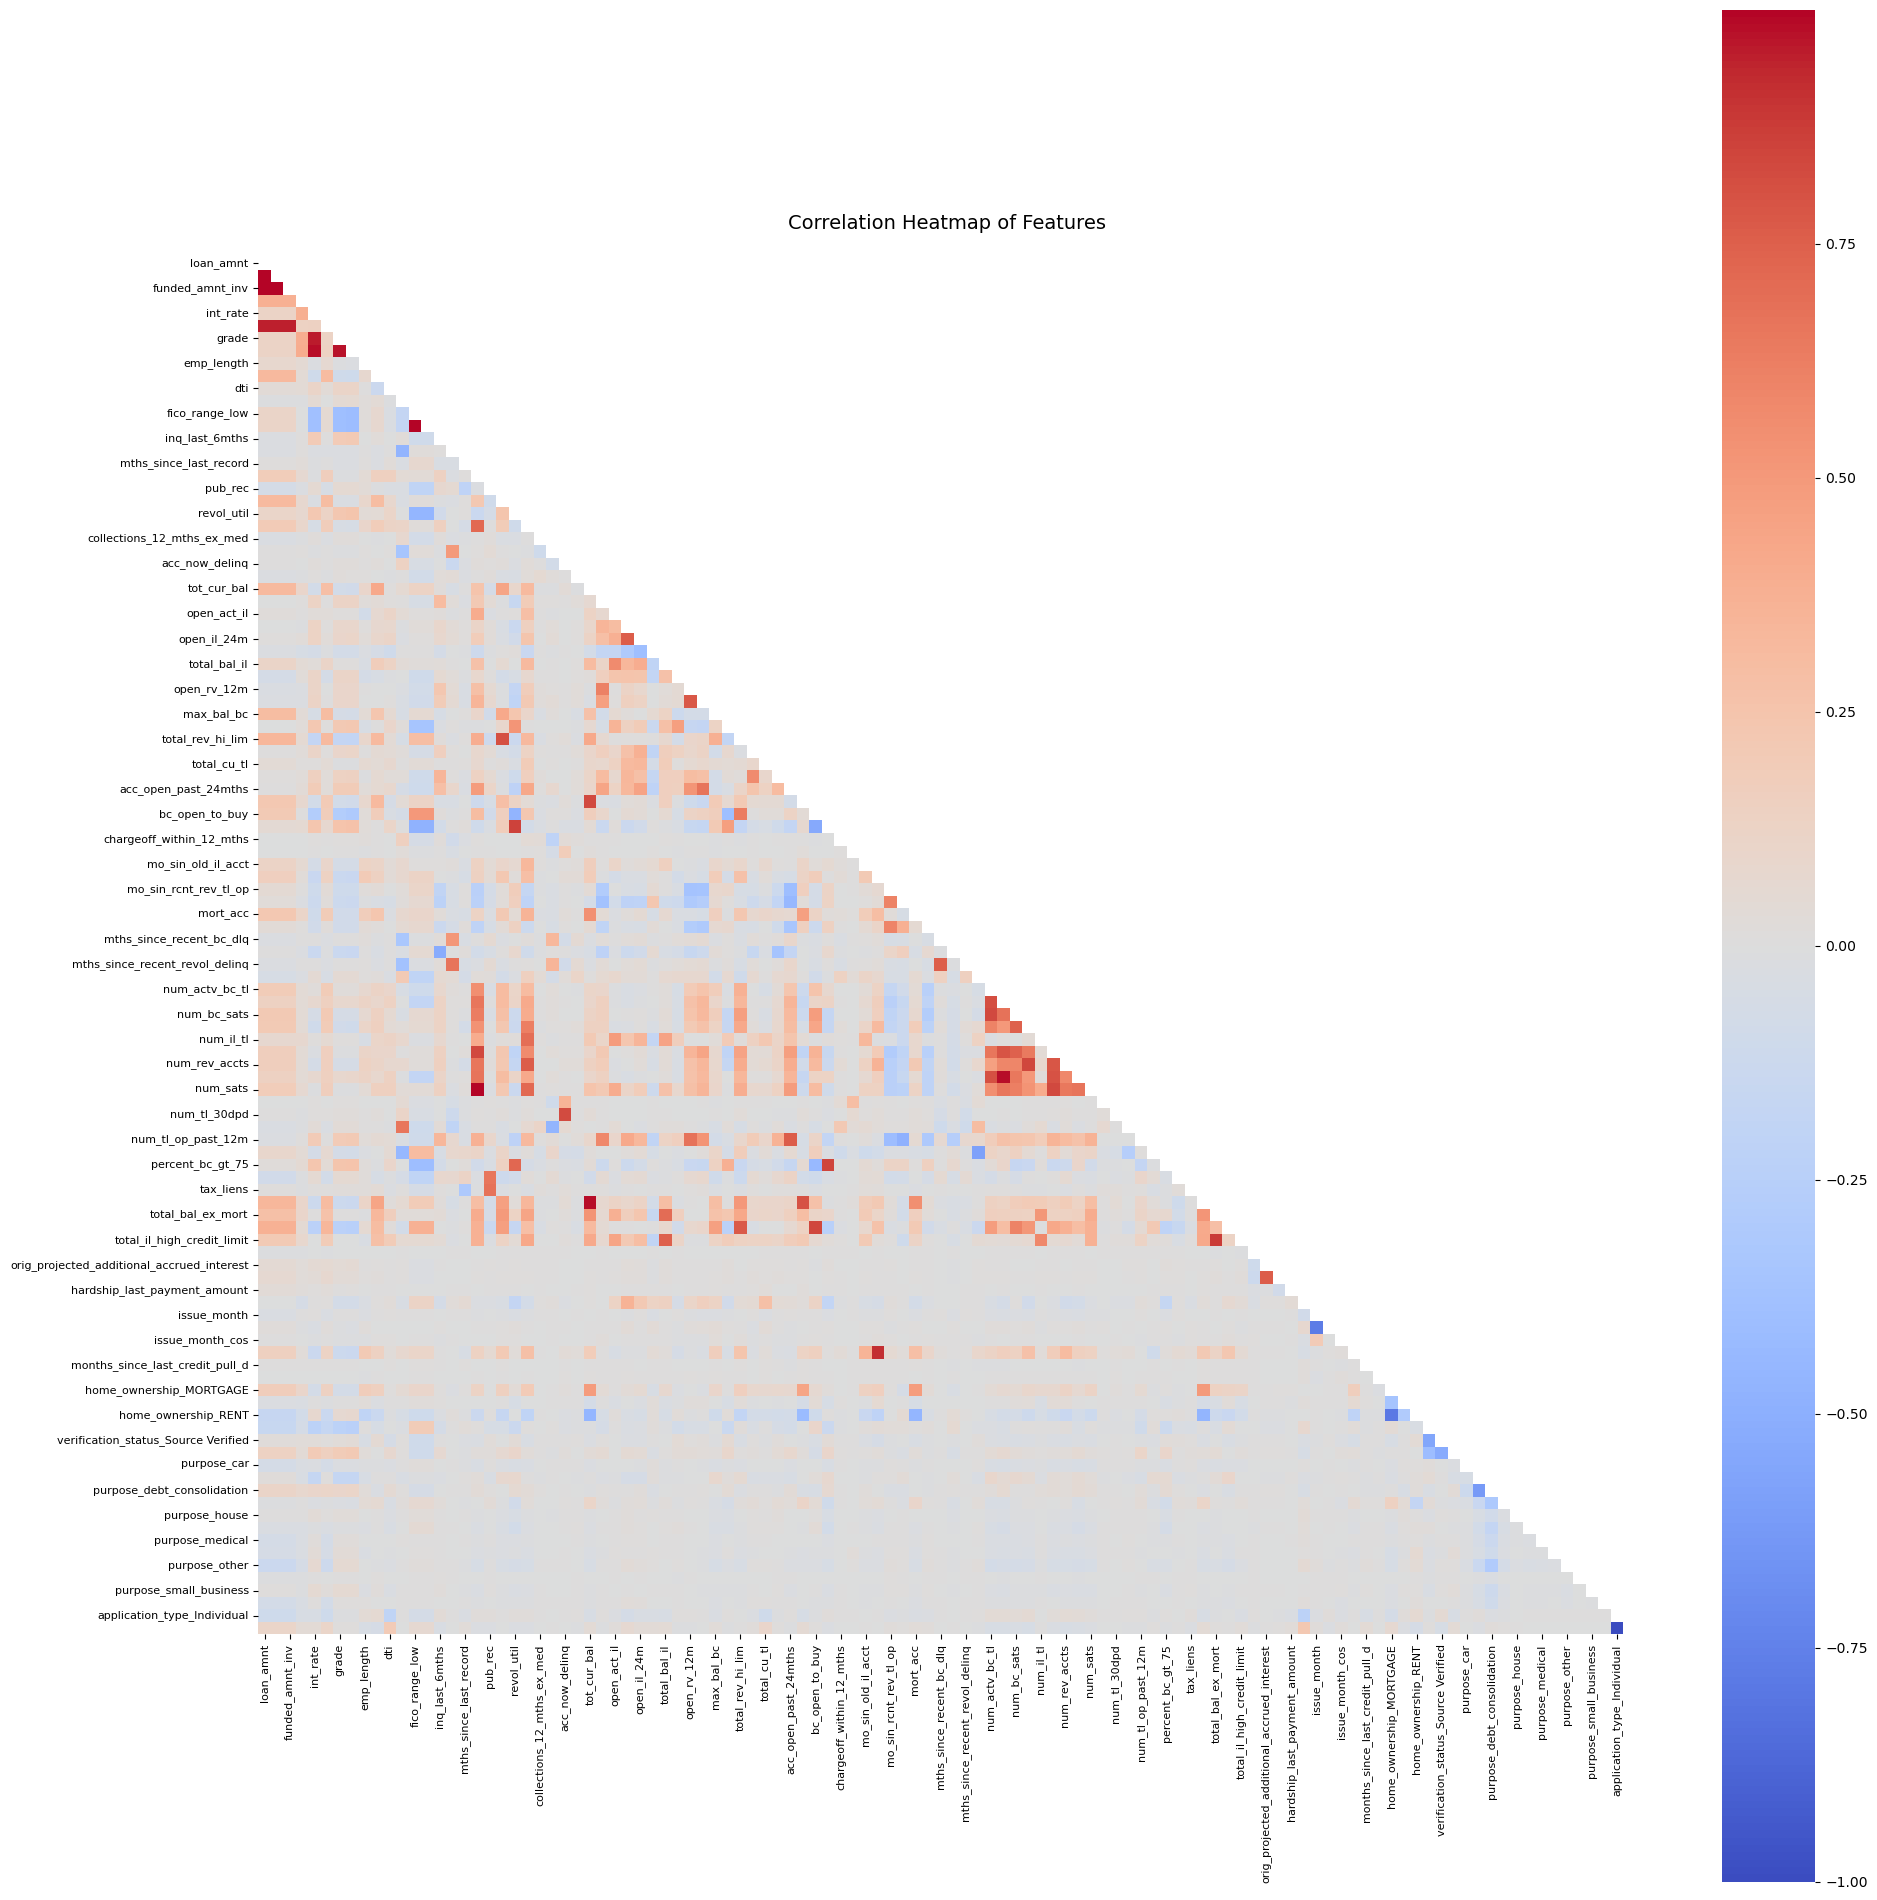

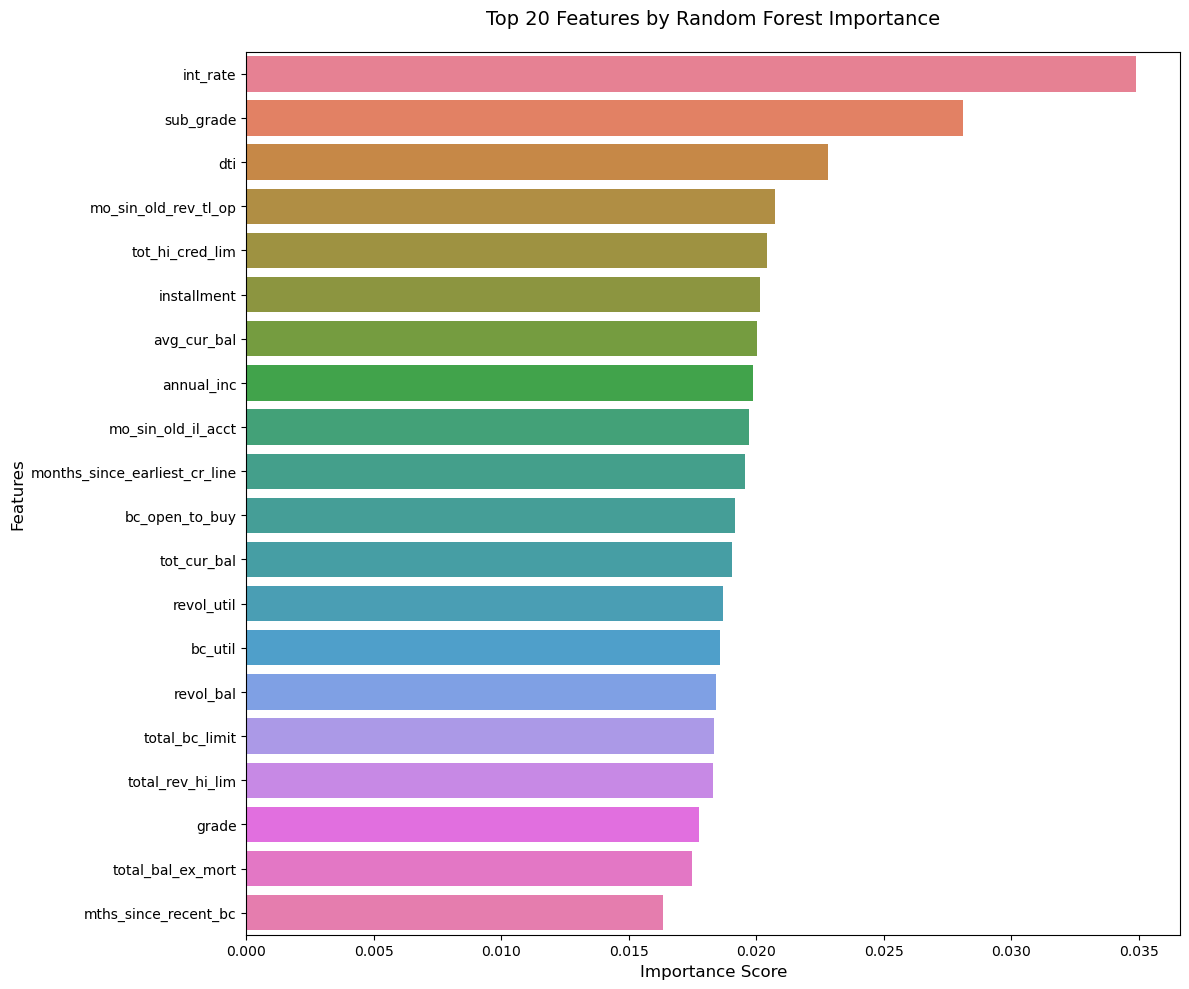


Top 20 Features and their Importance Scores:
                      Feature  RF_Importance
                     int_rate       0.034878
                    sub_grade       0.028106
                          dti       0.022797
         mo_sin_old_rev_tl_op       0.020739
              tot_hi_cred_lim       0.020427
                  installment       0.020160
                  avg_cur_bal       0.020037
                   annual_inc       0.019879
           mo_sin_old_il_acct       0.019716
months_since_earliest_cr_line       0.019550
               bc_open_to_buy       0.019161
                  tot_cur_bal       0.019047
                   revol_util       0.018712
                      bc_util       0.018594
                    revol_bal       0.018415
               total_bc_limit       0.018341
             total_rev_hi_lim       0.018310
                        grade       0.017765
            total_bal_ex_mort       0.017482
         mths_since_recent_bc       0.016325


In [13]:
plt.figure(figsize=(20, 20))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, 
            mask=mask,
            cmap='coolwarm', 
            center=0,
            annot=False,
            fmt='.2f',
            square=True)
plt.title('Correlation Heatmap of Features', pad=20, fontsize=14)
plt.xticks(rotation=90, fontsize=8) 
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

#Visualize top 20 feature importance
plt.figure(figsize=(12, 10)) 
top_20_features = feature_analysis.sort_values('RF_Importance', ascending=False).head(20)
top_20_features = top_20_features.reset_index(drop=True)
top_20_features['Rank'] = top_20_features.index + 1
sns.barplot(x='RF_Importance', 
            y='Feature',
            data=top_20_features,
            hue='Feature',
            legend=False)
plt.title('Top 20 Features by Random Forest Importance', pad=20, fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

print('\nTop 20 Features and their Importance Scores:')
print(top_20_features[['Feature', 'RF_Importance']].to_string(index=False))

#### h. Feature selection and threshold optimization

In [14]:
print('Testing different threshold combinations:')

# Define range of thresholds to try - these ones worked well
rf_thresholds = [0.003, 0.005, 0.01, 0.02]
corr_thresholds = [0.02, 0.04, 0.07]

# Track results
best_f1 = 0
best_rf_threshold = 0
best_corr_threshold = 0
best_feature_count = 0
best_features = []

for rf_threshold in rf_thresholds:
    for corr_threshold in corr_thresholds:
        # Apply thresholds to select features
        selected_features = feature_analysis[
            (feature_analysis['RF_Importance'] >= rf_threshold) | 
            (feature_analysis['Abs_Correlation'] >= corr_threshold)
        ]['Feature'].tolist()
        
        # Add must-have features based on domain knowledge
        features_to_always_keep = [
            'revol_util',  # Need in credit risk assessment
            'grade',       # Core creditworthiness indicator
            'term',        # Important loan characteristic
            'int_rate',    # Important to risk assessment
            'loan_amnt'    # Need for visualizations and business context
        ]
        features_to_always_keep = [f for f in features_to_always_keep if f in X_train_imputed.columns]
        
        for feature in features_to_always_keep:
            if feature not in selected_features:
                selected_features.append(feature)
        
        # Handle highly correlated features
        features_to_remove = set()
        for pair in high_correlation:
            var1, var2 = pair['var1'], pair['var2']
            if var1 in features_to_always_keep or var2 in features_to_always_keep:
                continue
            
            if var1 in selected_features and var2 in selected_features:
                imp1 = feature_analysis.loc[feature_analysis['Feature'] == var1, 'RF_Importance'].values[0]
                imp2 = feature_analysis.loc[feature_analysis['Feature'] == var2, 'RF_Importance'].values[0]
                
                if imp1 >= imp2:
                    features_to_remove.add(var2)
                else:
                    features_to_remove.add(var1)
        
        # Final features for this threshold combination
        threshold_features = [f for f in selected_features if f not in features_to_remove]
        
        # Only evaluate if we have a reasonable feature set
        if len(threshold_features) >= 5:
            # Quick model evaluation - SAME dataset for training and evaluation
            X_train_selected = X_train_imputed[threshold_features]
            X_test_selected = X_test_imputed[threshold_features]
            
            model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
            model.fit(X_train_selected, y_train)
            y_pred = model.predict(X_test_selected)
            f1 = f1_score(y_test, y_pred)
            
            print(f'  RF threshold: {rf_threshold}, Corr threshold: {corr_threshold}, ' +
                  f'Features: {len(threshold_features)}, F1: {f1:.4f}')
            
            # Update best if improved
            if f1 > best_f1:
                best_f1 = f1
                best_rf_threshold = rf_threshold
                best_corr_threshold = corr_threshold
                best_feature_count = len(threshold_features)
                best_features = threshold_features.copy()

# Print results of optimization
print(f'\nOptimal thresholds:')
print(f'- RF Importance threshold: {best_rf_threshold}')
print(f'- Correlation threshold: {best_corr_threshold}')
print(f'- Feature count: {best_feature_count}')
print(f'- F1 Score: {best_f1:.4f}')

# Use the BEST features found during the optimization
print('\nSelected features:')
for feat in sorted(best_features):
    if feat in feature_analysis['Feature'].values:
        imp = feature_analysis.loc[feature_analysis['Feature'] == feat, 'RF_Importance'].values[0]
        corr = feature_analysis.loc[feature_analysis['Feature'] == feat, 'Abs_Correlation'].values[0]
        print(f'- {feat}: RF_Importance={imp:.4f}, Correlation={corr:.4f}')

X_train_final = X_train_imputed[best_features]
X_test_final = X_test_imputed[best_features]

print(f'\nFeature Selection Summary:')
print(f'Features before processing: {X_train_imputed.shape[1]}') 
print(f'Features removed: {X_train_imputed.shape[1] - X_train_final.shape[1]}')
print(f'Current number of features: {X_train_final.shape[1]}') 
print(f'Expected F1 score with optimized features: {best_f1:.4f}')

#Store the feature list for reference
selected_features_list = best_features.copy()

Testing different threshold combinations:
  RF threshold: 0.003, Corr threshold: 0.02, Features: 57, F1: 0.0750
  RF threshold: 0.003, Corr threshold: 0.04, Features: 53, F1: 0.0789
  RF threshold: 0.003, Corr threshold: 0.07, Features: 53, F1: 0.0789
  RF threshold: 0.005, Corr threshold: 0.02, Features: 55, F1: 0.0744
  RF threshold: 0.005, Corr threshold: 0.04, Features: 51, F1: 0.0875
  RF threshold: 0.005, Corr threshold: 0.07, Features: 50, F1: 0.0815
  RF threshold: 0.01, Corr threshold: 0.02, Features: 47, F1: 0.0741
  RF threshold: 0.01, Corr threshold: 0.04, Features: 43, F1: 0.0891
  RF threshold: 0.01, Corr threshold: 0.07, Features: 37, F1: 0.0904
  RF threshold: 0.02, Corr threshold: 0.02, Features: 41, F1: 0.0870
  RF threshold: 0.02, Corr threshold: 0.04, Features: 33, F1: 0.0874
  RF threshold: 0.02, Corr threshold: 0.07, Features: 19, F1: 0.1140

Optimal thresholds:
- RF Importance threshold: 0.02
- Correlation threshold: 0.07
- Feature count: 19
- F1 Score: 0.1140

S

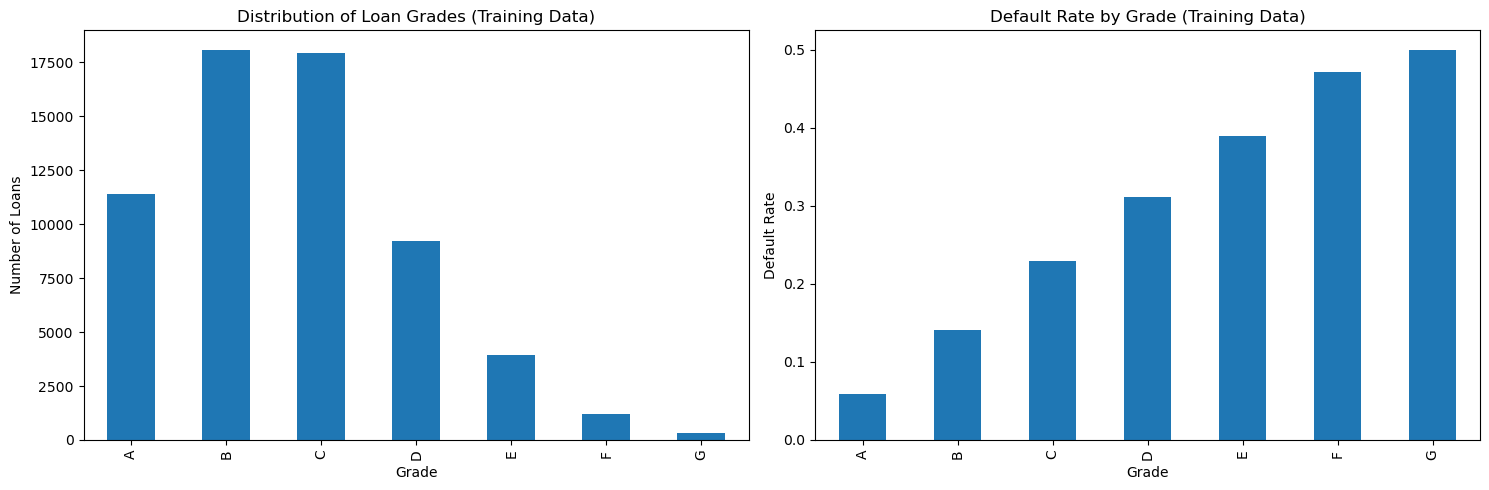

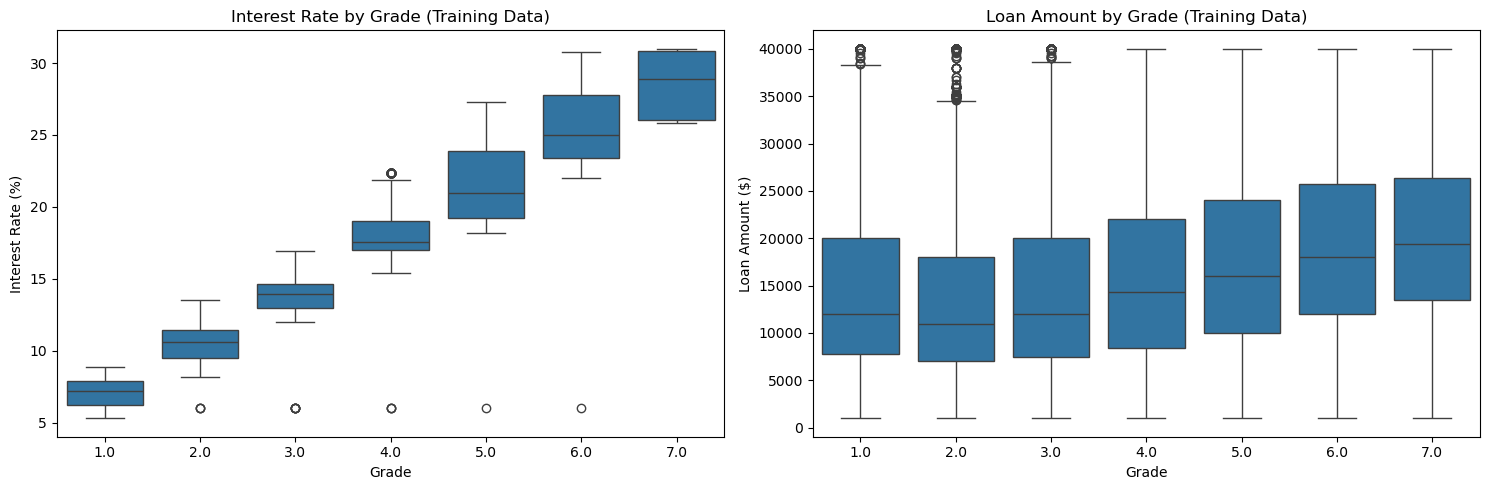

In [15]:
#1. Grade distribution with default rates
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
if 'grade' in X_train.columns:  # Change: use X_train instead of df_transformed
    X_train['grade'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Loan Grades (Training Data)')
    plt.xlabel('Grade')
    plt.ylabel('Number of Loans')

plt.subplot(1, 2, 2)
if 'grade' in X_train.columns:
    train_data = X_train.copy()
    train_data['loan_outcome'] = y_train
    default_by_grade = train_data.groupby('grade')['loan_outcome'].mean()
    default_by_grade.plot(kind='bar')
    plt.title('Default Rate by Grade (Training Data)')
    plt.xlabel('Grade')
    plt.ylabel('Default Rate')

plt.tight_layout()
plt.show()

#2. Distribution of int_rate vs loan amount
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='grade', y='int_rate', data=X_train_imputed)  
plt.title('Interest Rate by Grade (Training Data)')
plt.xlabel('Grade')
plt.ylabel('Interest Rate (%)')

plt.subplot(1, 2, 2)
sns.boxplot(x='grade', y='loan_amnt', data=X_train_imputed) 
plt.title('Loan Amount by Grade (Training Data)')
plt.xlabel('Grade')
plt.ylabel('Loan Amount ($)')

plt.tight_layout()
plt.show()

#### i. Apply necessary data transformations, such as normalization or standardization

In [16]:
#Apply StandardScaler 
scaler = StandardScaler()
scaler.fit(X_train_final)  

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_final), 
    columns=X_train_final.columns,
    index=X_train_final.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=X_test_final.columns,
    index=X_test_final.index
)

#Check class balance (for both train and test)
print('nClass distribution (training data):')
print(y_train.value_counts(normalize=True))

print('\nClass distribution (test data):')
print(y_test.value_counts(normalize=True))

nClass distribution (training data):
loan_outcome
0    0.799044
1    0.200956
Name: proportion, dtype: float64

Class distribution (test data):
loan_outcome
0    0.799047
1    0.200953
Name: proportion, dtype: float64


# Model Creation and Interpretation

In [17]:
#Use SMOTEENN to balance the training dataset
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f'Training set shape after resampling: {X_train_resampled.shape}')
print('Class distribution after resampling:')
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Training set shape after resampling: (67693, 19)
Class distribution after resampling:
loan_outcome
1    0.660172
0    0.339828
Name: proportion, dtype: float64


In [18]:
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):
    """
    Evaluate a model and return metrics and ROC curve data
    """
    # Get probability predictions (ensure numeric type)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test) if hasattr(model, "decision_function") else None
    
    # Make predictions using model's predict method instead of thresholding
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Predictions': y_pred
    }
    
    # Calculate ROC curve data
    roc_data = None
    if y_prob is not None:
        metrics['ROC AUC'] = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_data = {
            'fpr': fpr,
            'tpr': tpr,
            'auc': metrics['ROC AUC']
        }
    
    return metrics, roc_data

#### a. Define models and parameters to evaluate

Training and evaluating models:

Training Logistic Regression

Training Random Forest


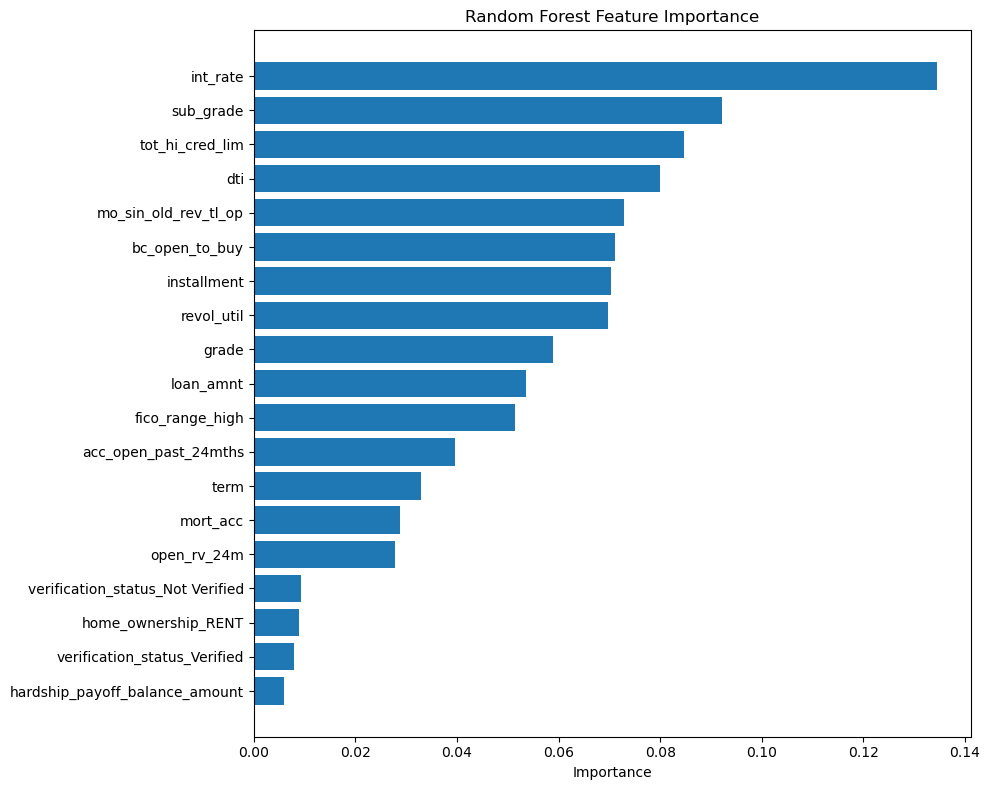


Training XGBoost


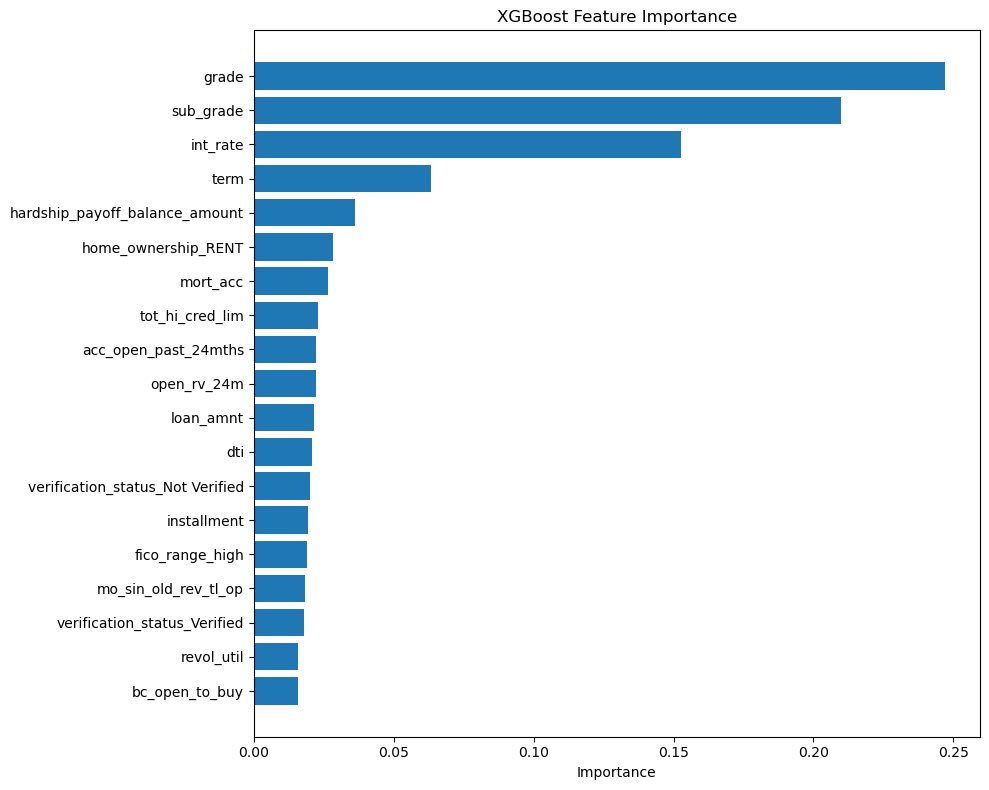


Training SVM

Training Neural Network

Training LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12484, number of negative: 49639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 62123, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


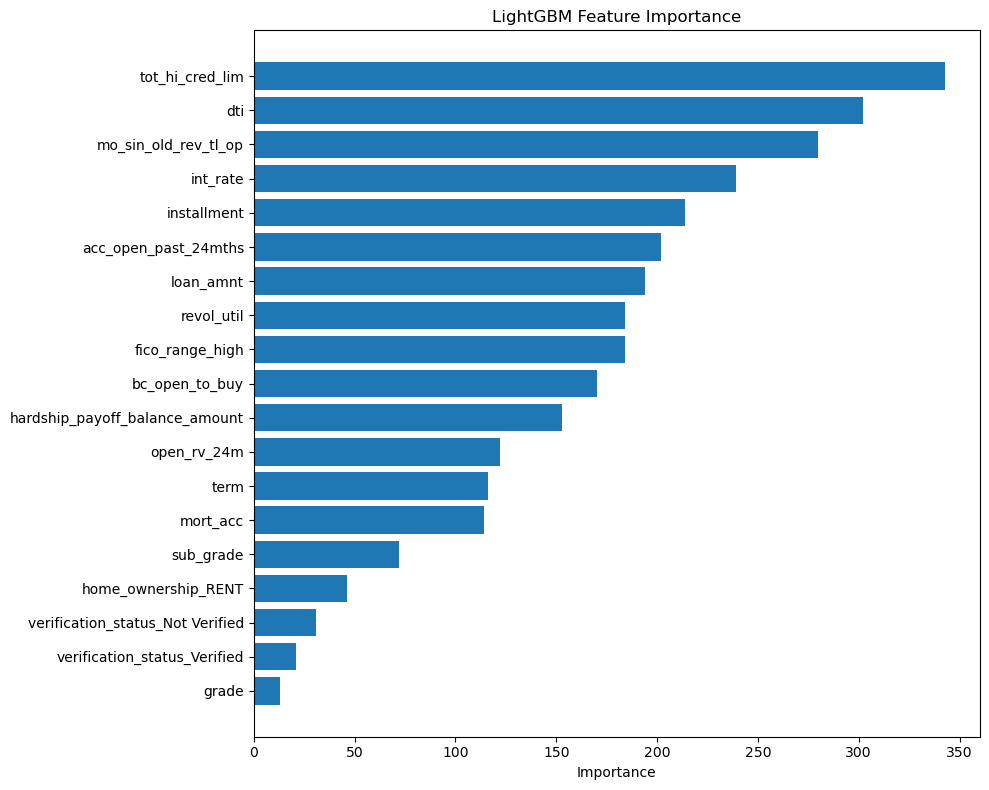


Training CatBoost


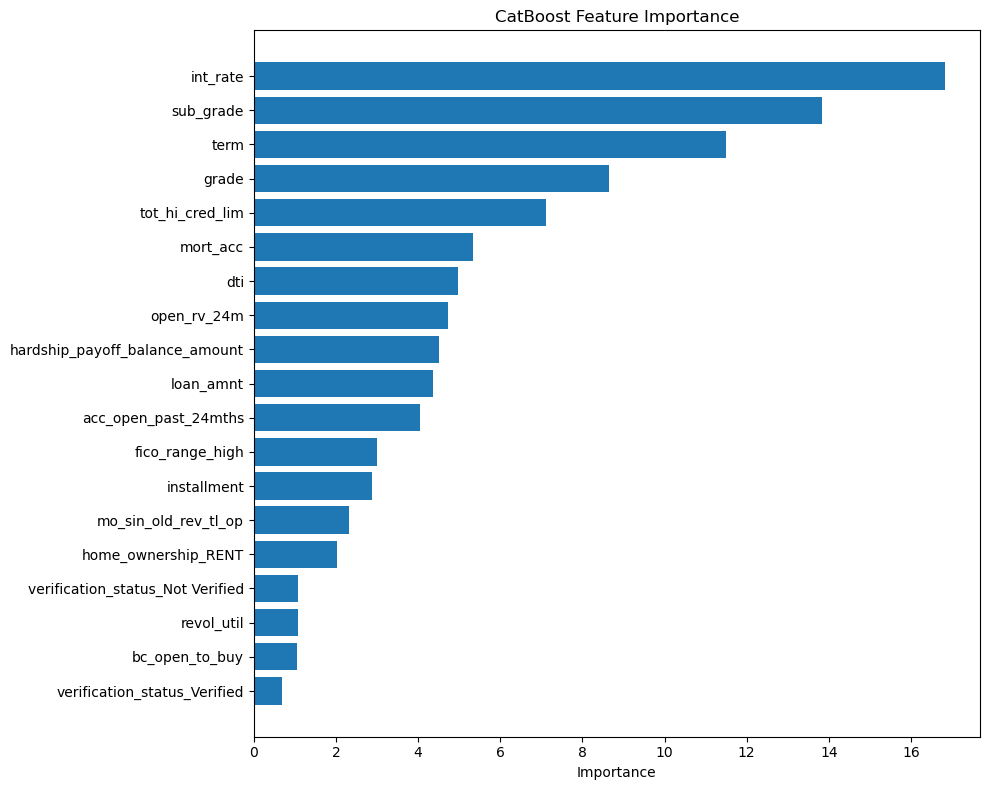


Model Performance (Sorted by F1 Score):
                     Accuracy  Precision  Recall      F1  ROC AUC
Model                                                            
LightGBM               0.6485     0.3177  0.6527  0.4274   0.7076
CatBoost               0.6391     0.3123  0.6623  0.4245   0.7052
Logistic Regression    0.6600     0.3205  0.6174  0.4219   0.6986
XGBoost                0.6490     0.3153  0.6370  0.4218   0.7045
Random Forest          0.7329     0.3687  0.4627  0.4104   0.6994
SVM                    0.5245     0.2427  0.6443  0.3526   0.5973
Neural Network         0.7991     1.0000  0.0003  0.0006   0.5000


In [ ]:
# Train models using the selected features from the optimization process
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        class_weight='balanced',
        C=0.1,  
        solver='liblinear'  
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=15, 
        min_samples_leaf=5,  
        class_weight='balanced', 
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,  
        learning_rate=0.05,  
        subsample=0.8,  
        colsample_bytree=0.8,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf', 
        probability=True, 
        class_weight='balanced',
        C=1.0,  #
        gamma='scale',
        random_state=42
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu', 
        solver='adam',
        alpha=0.001,  
        batch_size=64,
        learning_rate='adaptive',
        max_iter=200, 
        random_state=42
    ),
    'LightGBM': lgb.LGBMClassifier(  
        n_estimators=100,
        num_leaves=31,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42
    ),
    'CatBoost': CatBoostClassifier( 
        iterations=100,
        depth=6,
        learning_rate=0.05,
        loss_function='Logloss',
        class_weights=[1, len(y_train[y_train==0])/len(y_train[y_train==1])],
        random_seed=42,
        verbose=0
    )
}

# Train and evaluate all models
results = []
all_roc_data = {}
confusion_matrices = {}

print('Training and evaluating models:')
for name, model in models.items():
    print(f'\nTraining {name}')
    
    # Use X_train_final and X_test_final consistently!
    try:
        model.fit(X_train_final, y_train)
        metrics, roc_data = evaluate_model(model, X_test_final, y_test, name)

        results.append(metrics)
        all_roc_data[name] = roc_data
        confusion_matrices[name] = confusion_matrix(y_test, metrics['Predictions'])
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[-20:]  # Top 20 features
            
            plt.figure(figsize=(10, 8))
            plt.barh(range(len(indices)), importances[indices])
            plt.yticks(range(len(indices)), [X_train_final.columns[i] for i in indices])
            plt.title(f'{name} Feature Importance')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue

# Create a DataFrame with results for easy comparison
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

# Display results sorted by F1 score (best model first)
display_cols = [col for col in results_df.columns if col != 'Predictions']
print("\nModel Performance (Sorted by F1 Score):")
print(results_df[display_cols].sort_values('F1', ascending=False).round(4))

#### b. Display model results


=== Model Performance Comparison ===
                     Accuracy  Precision  Recall      F1  ROC AUC
Model                                                            
Logistic Regression    0.6600     0.3205  0.6174  0.4219   0.6986
Random Forest          0.7329     0.3687  0.4627  0.4104   0.6994
XGBoost                0.6490     0.3153  0.6370  0.4218   0.7045
SVM                    0.5245     0.2427  0.6443  0.3526   0.5973
Neural Network         0.7991     1.0000  0.0003  0.0006   0.5000
LightGBM               0.6485     0.3177  0.6527  0.4274   0.7076
CatBoost               0.6391     0.3123  0.6623  0.4245   0.7052


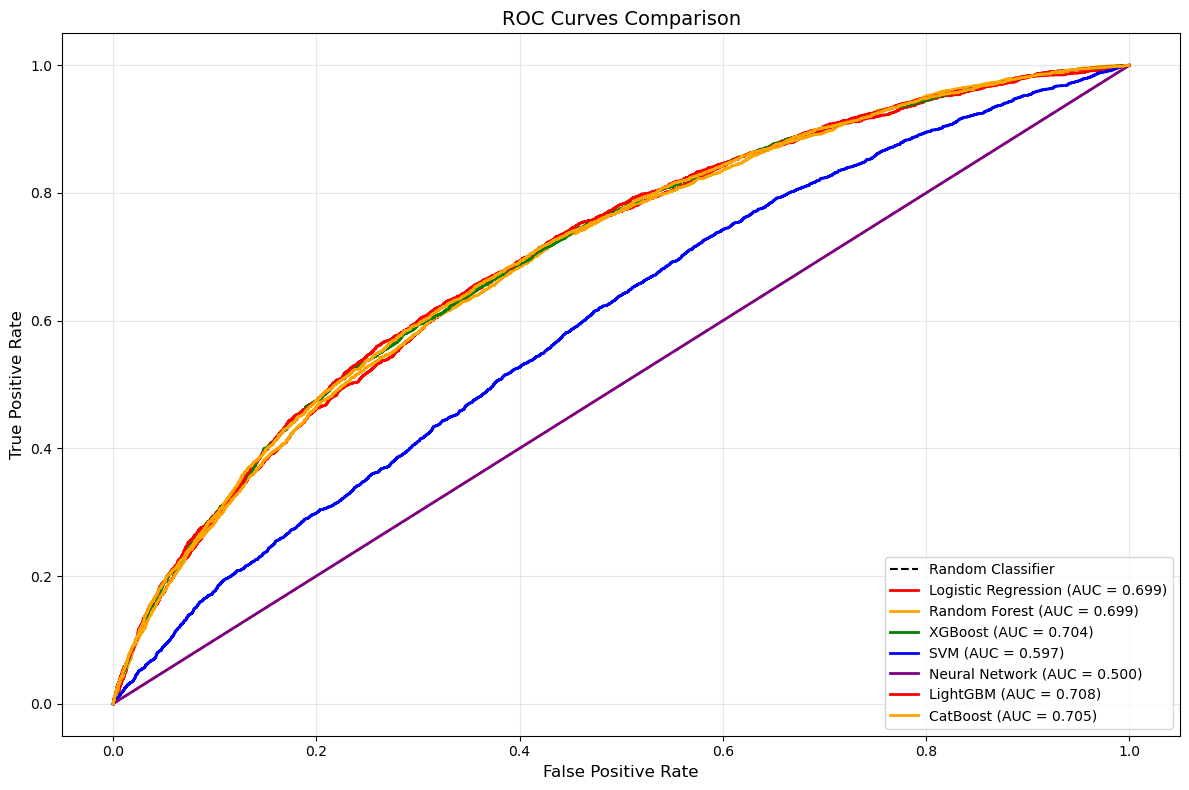

In [29]:
# 1. Display Performance Metrics Table
print('\n=== Model Performance Comparison ===')
display_cols = [col for col in results_df.columns if col != 'Predictions']
print(results_df[display_cols].round(4))

# 2. Plot ROC curves for all models
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

colors = ['red', 'orange', 'green', 'blue', 'purple']
for i, (name, data) in enumerate(all_roc_data.items()):
    if data is not None:
        plt.plot(data['fpr'], data['tpr'], color=colors[i % len(colors)], linewidth=2,
                 label=f'{name} (AUC = {data["auc"]:.3f})')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_roc.png', dpi=300)
plt.show()

In [30]:
#Extract specific models for further analysis
best_rf = models['Random Forest']
best_xgb = models['XGBoost']

# Evaluate them with specific names needed for your threshold optimization
rf_metrics, rf_roc = evaluate_model(best_rf, X_test_final, y_test, "Random Forest with Class Weights")
xgb_metrics, xgb_roc = evaluate_model(best_xgb, X_test_final, y_test, "XGBoost with Scale Pos Weight")

# Create confusion matrices
rf_cm = confusion_matrix(y_test, rf_metrics['Predictions'])
xgb_cm = confusion_matrix(y_test, xgb_metrics['Predictions'])

# Store results for comparison
weighted_results = [rf_metrics, xgb_metrics]
weighted_roc_data = {
    "Random Forest with Class Weights": rf_roc,
    "XGBoost with Scale Pos Weight": xgb_roc
}

# Display metrics
print("Models with Class Weights")
weighted_df = pd.DataFrame(weighted_results)
weighted_df = weighted_df.set_index('Model')

# Remove 'Predictions' column for display
display_cols = [col for col in weighted_df.columns if col != 'Predictions']
print(weighted_df[display_cols].round(4))

Models with Class Weights
                                  Accuracy  Precision  Recall      F1  ROC AUC
Model                                                                         
Random Forest with Class Weights    0.7329     0.3687  0.4627  0.4104   0.6994
XGBoost with Scale Pos Weight       0.6490     0.3153  0.6370  0.4218   0.7045


# Model Implementation

#### a. Comparison of different models' confidence matrices

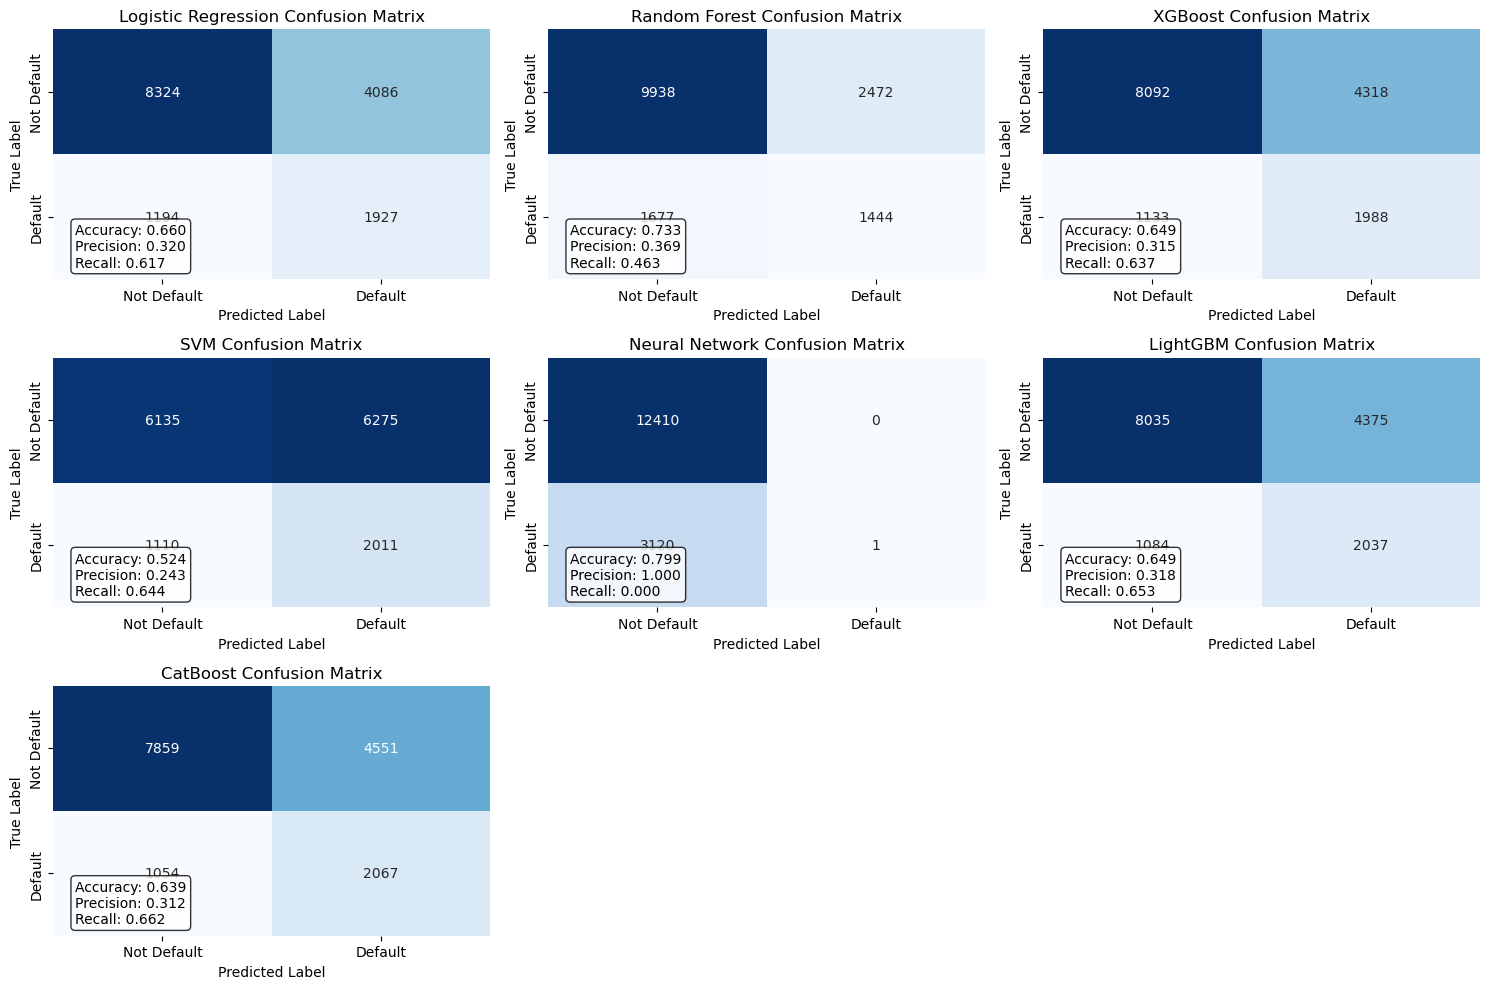

In [25]:
# Plot confusion matrices for all models
plt.figure(figsize=(15, 10))
model_names = list(confusion_matrices.keys())
n_models = len(model_names)
rows = (n_models + 2) // 3  # Calculate rows needed (3 models per row)

for i, model_name in enumerate(model_names):
    plt.subplot(rows, 3, i+1)
    cm = confusion_matrices[model_name]
    
    # Normalize the confusion matrix for better visualization
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot both raw numbers and percentages
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks([0.5, 1.5], ['Not Default', 'Default'])
    plt.yticks([0.5, 1.5], ['Not Default', 'Default'])
    
    # Add metrics as text
    tn, fp, fn, tp = cm.ravel()
    plt.annotate(f'Accuracy: {(tn+tp)/(tn+fp+fn+tp):.3f}\nPrecision: {tp/(tp+fp) if tp+fp>0 else 0:.3f}\nRecall: {tp/(tp+fn) if tp+fn>0 else 0:.3f}', 
                xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.show()


Analyzing Logistic Regression...

=== Logistic Regression ANALYSIS ===
Optimal threshold: 0.75
Business impact by threshold:
              TN     FP    FN    TP      Net Impact    ROI
Threshold                                                 
0.25        1709  10701   101  3020  $11,869,700.00  3.99x
0.30        2800   9610   213  2908  $19,427,500.00  5.34x
0.40        5516   6894   600  2521  $37,322,800.00  6.68x
0.50        8324   4086  1194  1927  $54,176,200.00  6.32x
0.60       10322   2088  1848  1273  $64,201,600.00  5.43x
0.70       11526    884  2413   708  $68,790,300.00  4.75x
0.75       11887    523  2638   483  $69,693,600.00  4.49x


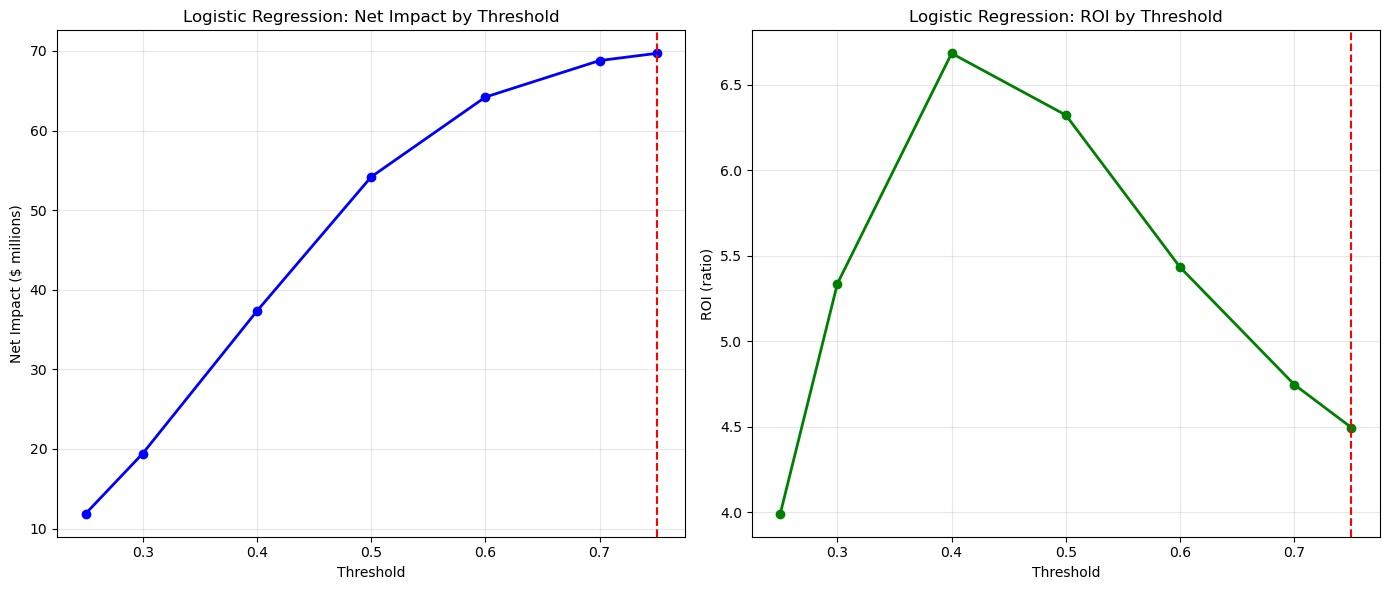


Analyzing Random Forest...

=== Random Forest ANALYSIS ===
Optimal threshold: 0.70
Business impact by threshold:
              TN    FP    FN    TP      Net Impact    ROI
Threshold                                                
0.25        3960  8450   354  2767  $27,277,000.00  6.26x
0.30        5193  7217   551  2570  $35,219,900.00  6.59x
0.40        7736  4674  1068  2053  $50,660,800.00  6.38x
0.50        9938  2472  1677  1444  $62,659,900.00  5.70x
0.60       11441   969  2363   758  $68,552,300.00  4.81x
0.70       12145   265  2833   288  $70,048,500.00  4.28x
0.75       12296   114  2990   131  $69,891,800.00  4.11x


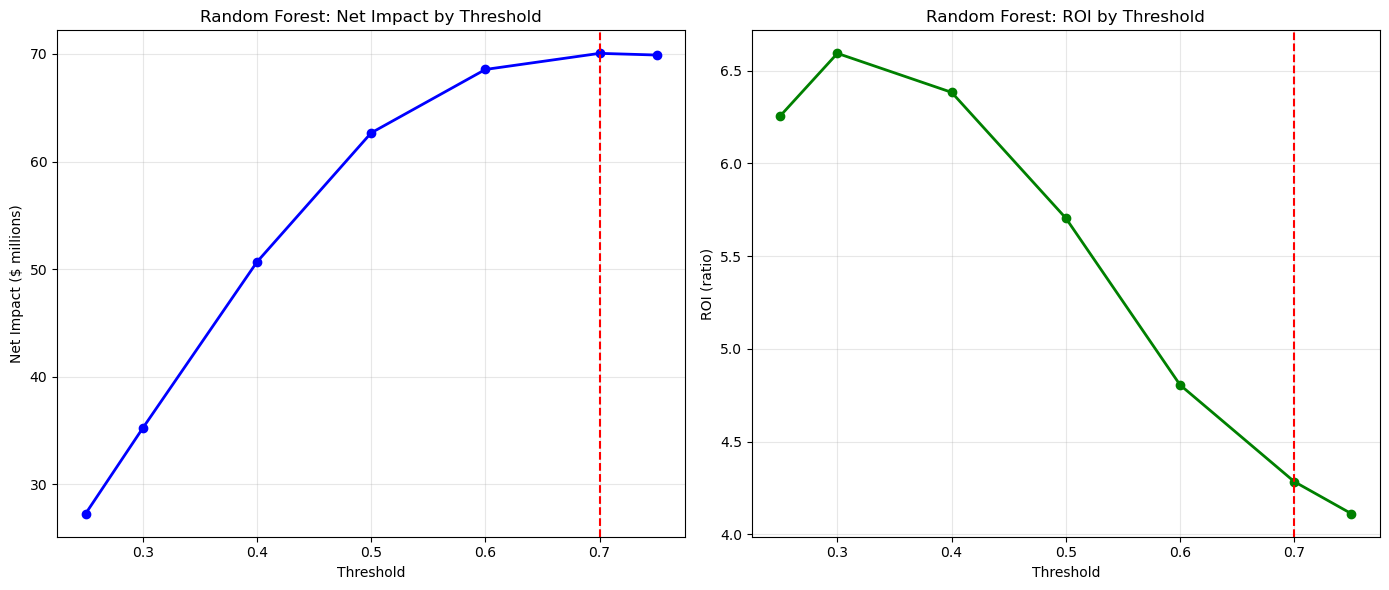


Analyzing XGBoost...

=== XGBoost ANALYSIS ===
Optimal threshold: 0.75
Business impact by threshold:
              TN    FP    FN    TP      Net Impact    ROI
Threshold                                                
0.25        2580  9830   179  2942  $18,000,500.00  5.19x
0.30        3471  8939   279  2842  $24,100,300.00  6.05x
0.40        5630  6780   598  2523  $38,229,000.00  6.86x
0.50        8092  4318  1133  1988  $52,885,100.00  6.40x
0.60       10223  2187  1750  1371  $64,262,400.00  5.66x
0.70       11610   800  2438   683  $69,233,000.00  4.74x
0.75       12024   386  2710   411  $70,150,200.00  4.43x


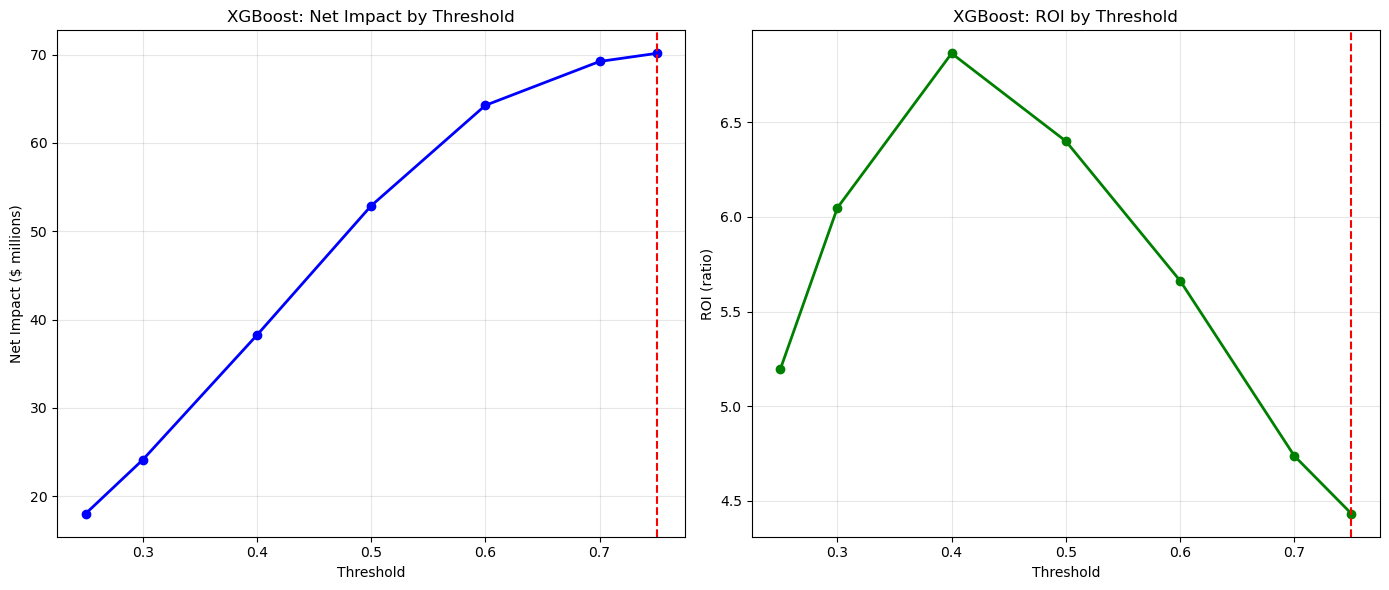


Analyzing SVM...

=== SVM ANALYSIS ===
Optimal threshold: 0.40
Business impact by threshold:
              TN    FP    FN    TP      Net Impact    ROI
Threshold                                                
0.25        9475  2935  2072  1049  $55,691,000.00  4.39x
0.30       12141   269  2992   129  $68,665,800.00  4.05x
0.40       12410     0  3120     1  $69,676,000.00  3.98x
0.50       12410     0  3121     0  $69,667,500.00  3.98x
0.60       12410     0  3121     0  $69,667,500.00  3.98x
0.70       12410     0  3121     0  $69,667,500.00  3.98x
0.75       12410     0  3121     0  $69,667,500.00  3.98x


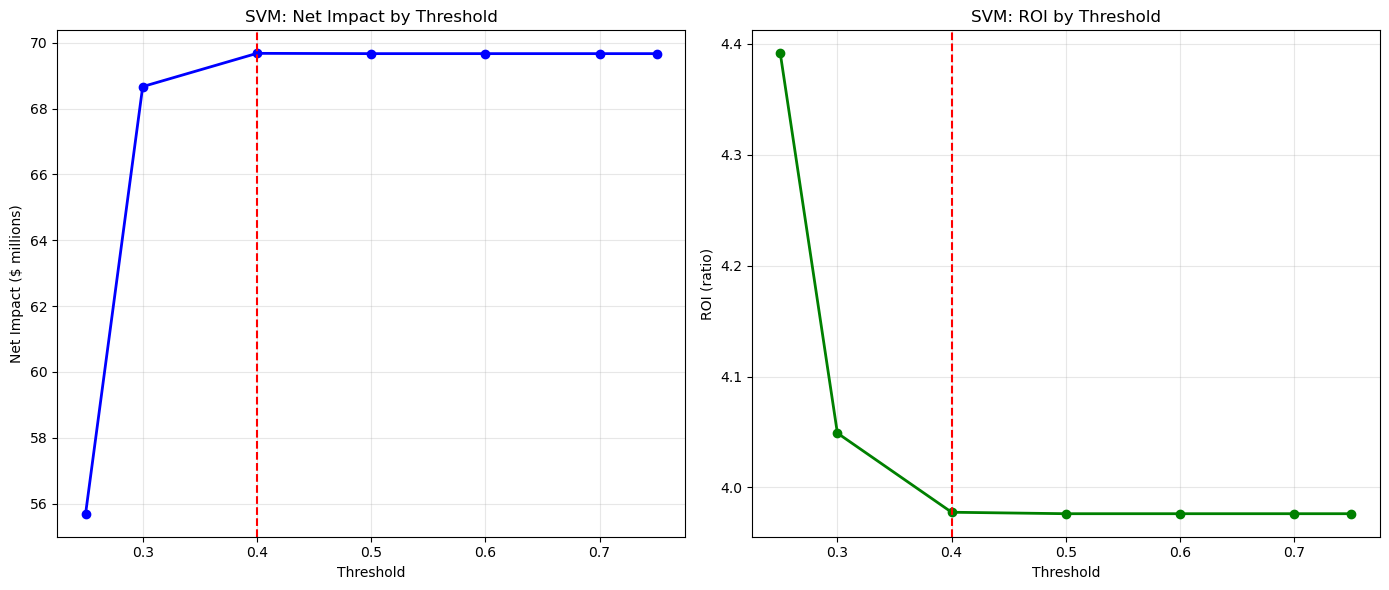


Analyzing Neural Network...

=== Neural Network ANALYSIS ===
Optimal threshold: 0.25
Business impact by threshold:
              TN  FP    FN  TP      Net Impact    ROI
Threshold                                            
0.25       12410   0  3120   1  $69,676,000.00  3.98x
0.30       12410   0  3120   1  $69,676,000.00  3.98x
0.40       12410   0  3120   1  $69,676,000.00  3.98x
0.50       12410   0  3120   1  $69,676,000.00  3.98x
0.60       12410   0  3121   0  $69,667,500.00  3.98x
0.70       12410   0  3121   0  $69,667,500.00  3.98x
0.75       12410   0  3121   0  $69,667,500.00  3.98x


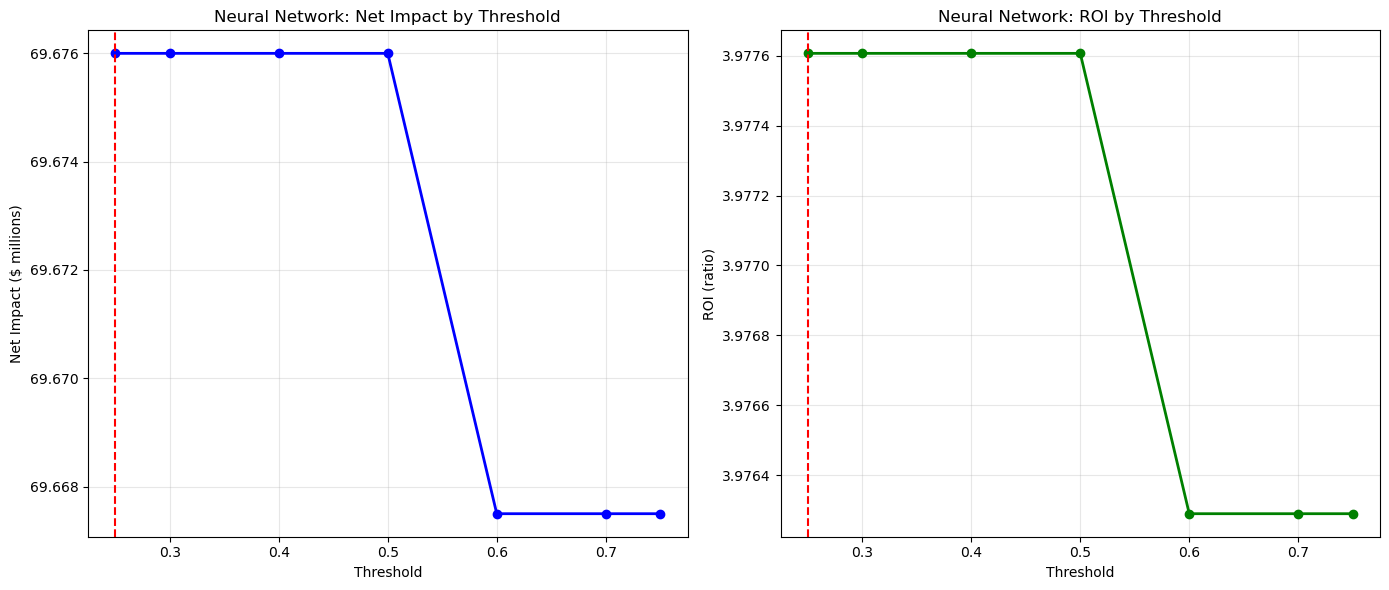


Analyzing LightGBM...

=== LightGBM ANALYSIS ===
Optimal threshold: 0.75
Business impact by threshold:
              TN    FP    FN    TP      Net Impact    ROI
Threshold                                                
0.25        2556  9854   166  2955  $17,923,800.00  5.27x
0.30        3470  8940   270  2851  $24,169,000.00  6.13x
0.40        5619  6791   585  2536  $38,253,700.00  6.95x
0.50        8035  4375  1084  2037  $52,857,000.00  6.60x
0.60       10108  2302  1694  1427  $63,841,400.00  5.77x
0.70       11575   835  2400   721  $69,283,000.00  4.80x
0.75       12045   365  2715   406  $70,271,500.00  4.43x


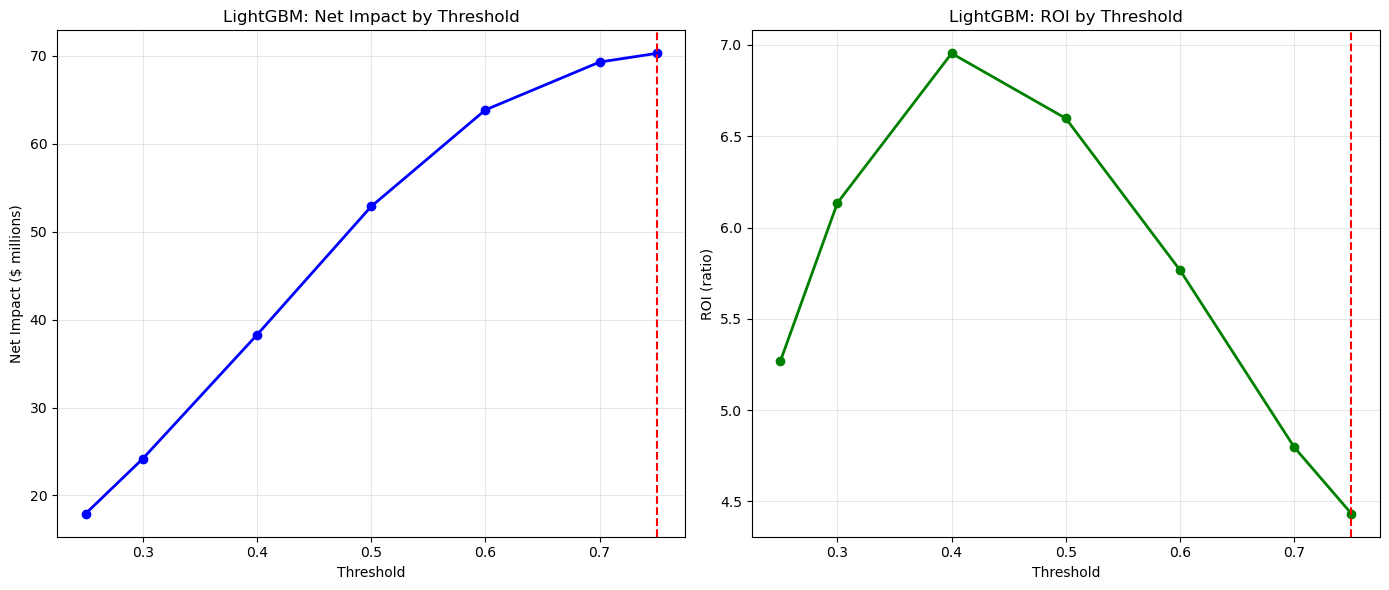


Analyzing CatBoost...

=== CatBoost ANALYSIS ===
Optimal threshold: 0.75
Business impact by threshold:
              TN     FP    FN    TP      Net Impact    ROI
Threshold                                                 
0.25        2368  10042   151  2970  $16,584,900.00  5.00x
0.30        3216   9194   255  2866  $22,315,300.00  5.78x
0.40        5315   7095   544  2577  $36,231,000.00  6.84x
0.50        7859   4551  1054  2067  $51,739,200.00  6.58x
0.60       10095   2315  1707  1414  $63,629,500.00  5.71x
0.70       11654    756  2458   663  $69,406,200.00  4.72x
0.75       12083    327  2755   366  $70,227,900.00  4.38x


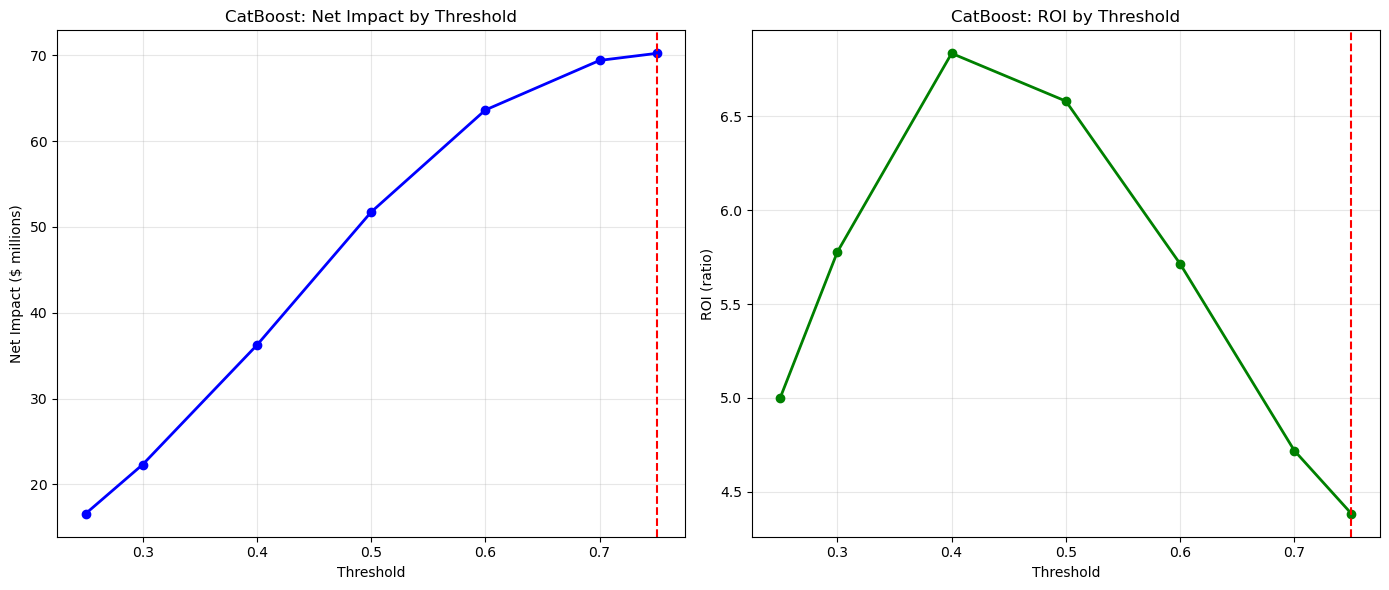


=== OPTIMAL THRESHOLD COMPARISON ===
                    Optimal Threshold      Net Impact    ROI       TN     FP      FN     TP
Model                                                                                      
LightGBM                         0.75  $70,271,500.00  4.43x  12045.0  365.0  2715.0  406.0
CatBoost                         0.75  $70,227,900.00  4.38x  12083.0  327.0  2755.0  366.0
XGBoost                          0.75  $70,150,200.00  4.43x  12024.0  386.0  2710.0  411.0
Random Forest                    0.70  $70,048,500.00  4.28x  12145.0  265.0  2833.0  288.0
Logistic Regression              0.75  $69,693,600.00  4.49x  11887.0  523.0  2638.0  483.0
SVM                              0.40  $69,676,000.00  3.98x  12410.0    0.0  3120.0    1.0
Neural Network                   0.25  $69,676,000.00  3.98x  12410.0    0.0  3120.0    1.0


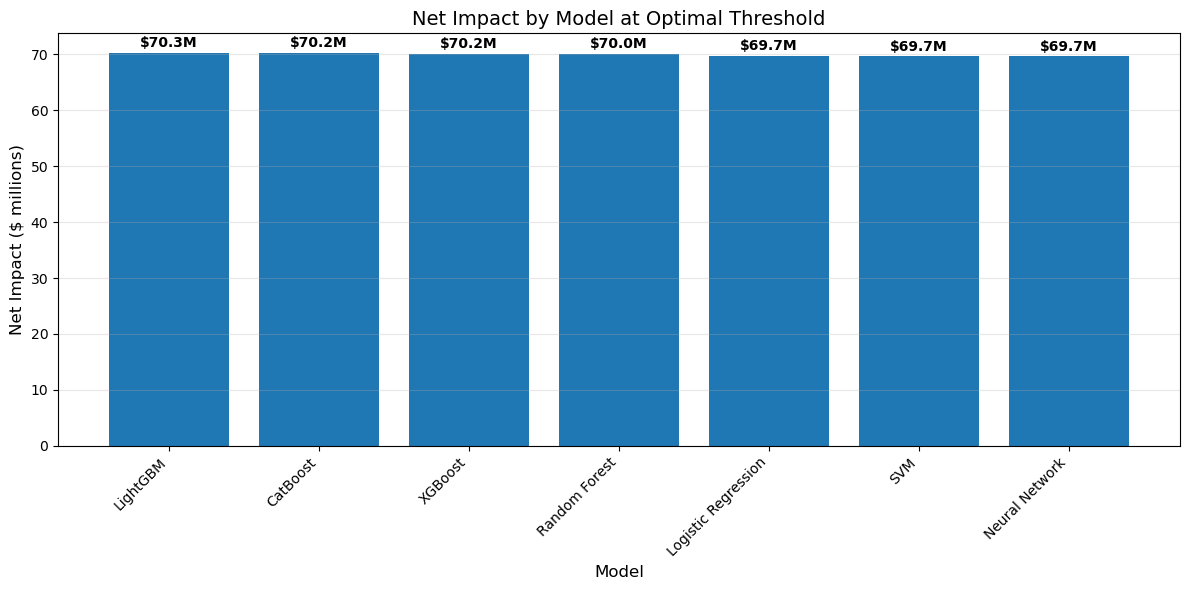

In [46]:
# Analyze models and gather threshold results
model_thresholds = {}

for model_name, model in models.items():
    # Skip models that aren't in the results dataframe (failed during training)
    if model_name not in results_df.index:
        continue
        
    # Analyze this model
    thresh_results, best_thresh = analyze_model_thresholds(model, X_test_final, y_test, model_name)
    model_thresholds[model_name] = {'best_threshold': best_thresh, 'results': thresh_results}

# Compare the optimal thresholds for all models
comparison_data = []

for model_name, threshold_data in model_thresholds.items():
    best_thresh = threshold_data['best_threshold']
    results = threshold_data['results']
    
    # Get metrics at optimal threshold
    opt_metrics = results.loc[best_thresh]
    
    comparison_data.append({
        'Model': model_name,
        'Optimal Threshold': best_thresh,
        'Net Impact': opt_metrics['Net Impact'],
        'ROI': opt_metrics['ROI'],
        'TN': opt_metrics['TN'],
        'FP': opt_metrics['FP'],
        'FN': opt_metrics['FN'],
        'TP': opt_metrics['TP']
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model').sort_values('Net Impact', ascending=False)

# Format for display
display_comparison = comparison_df.copy()
display_comparison['Optimal Threshold'] = display_comparison['Optimal Threshold'].apply(lambda x: f"{x:.2f}")
display_comparison['Net Impact'] = display_comparison['Net Impact'].apply(lambda x: f"${x:,.2f}")
display_comparison['ROI'] = display_comparison['ROI'].apply(lambda x: f"{x:.2f}x")

print("\n=== OPTIMAL THRESHOLD COMPARISON ===")
print(display_comparison)

# Create a bar chart comparing net impact
plt.figure(figsize=(12, 6))
bars = plt.bar(comparison_df.index, comparison_df['Net Impact'] / 1000000)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'${height:.1f}M', ha='center', va='bottom', fontweight='bold')

plt.title('Net Impact by Model at Optimal Threshold', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Net Impact ($ millions)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Found 3718 open loans
Open loan statuses found: ['Current' 'Late (31-120 days)' 'In Grace Period' 'Late (16-30 days)']
Preprocessing open loans data...


/var/folders/71/_3733kxx5blfhjkyksrj14b40000gn/T/ipykernel_1095/1473363160.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_prepared[col] = pd.to_numeric(X_prepared[col], errors='ignore')
/var/folders/71/_3733kxx5blfhjkyksrj14b40000gn/T/ipykernel_1095/1473363160.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_prepared[col] = pd.to_numeric(X_prepared[col], errors='ignore')
/var/folders/71/_3733kxx5blfhjkyksrj14b40000gn/T/ipykernel_1095/1473363160.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_prepared[col] = pd.to_numeric(X_prepared[col], errors='ignore')


Adding 4 missing columns from training data
Removing 6710 extra columns not in training data
Prepared 3718 open loans with 19 features for analysis

=== APPLYING BEST MODEL (LightGBM) TO OPEN LOANS ===
Using optimal threshold: 0.75

=== LOAN ANALYSIS BY CREDIT GRADE ===
  Grade  Loan Count Total Investment Avg Interest Rate Avg Default Probability Expected Net Return (All) Expected ROI (All)  Approved Count Approval Rate Approved Investment Expected Net Return (Approved) Expected ROI (Approved)
5     A         136    $2,666,575.00             7.59%                  24.50%              $-351,446.02            -13.18%             136       100.00%       $2,666,575.00                   $-351,446.02                 -13.18%
1     B         653   $13,430,700.00            11.09%                  40.10%            $-3,130,136.27            -23.31%             626        95.87%      $12,872,150.00                 $-2,814,184.48                 -21.86%
3     C        2036   $42,734,325.00      

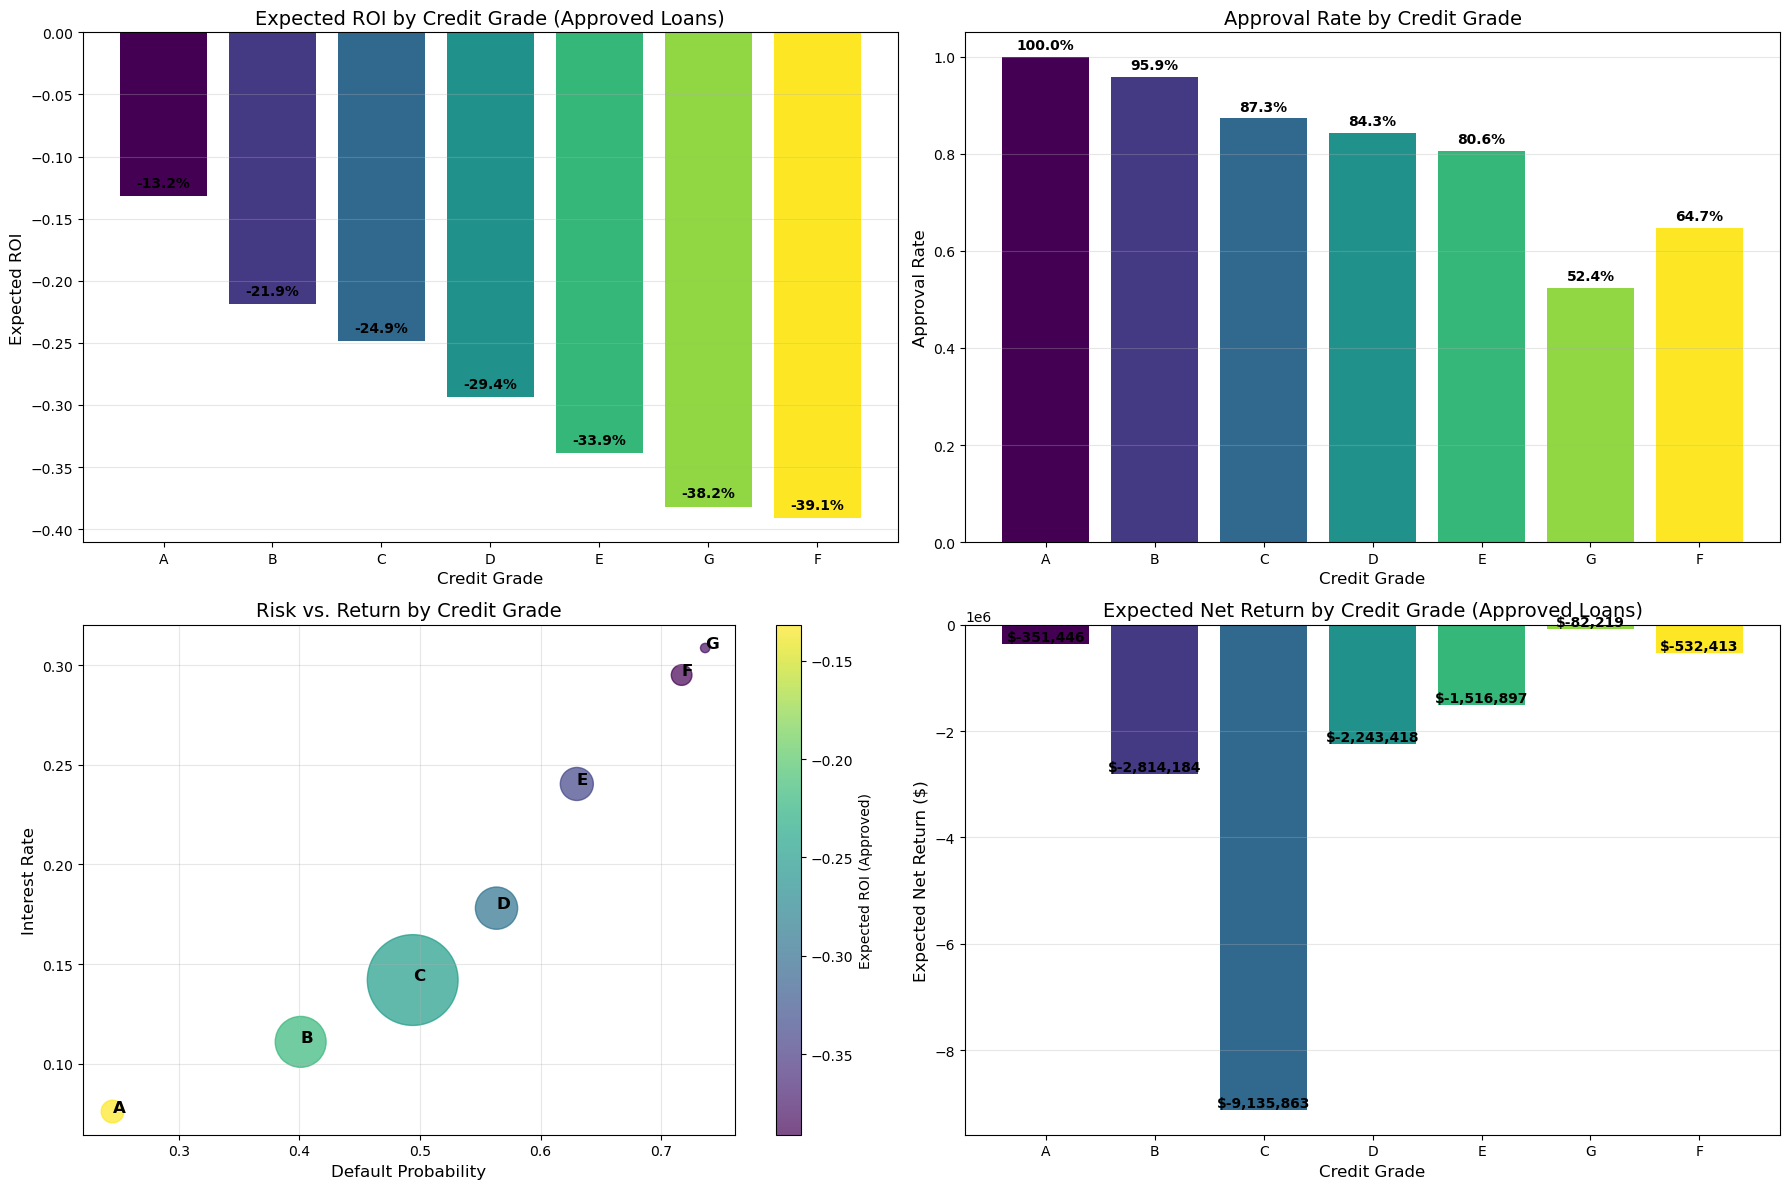


=== OPTIMAL INVESTMENT STRATEGY ===
Total investment portfolio: $65,954,925.00
Recommended allocation by credit grade (based on ROI):
No grades with positive expected ROI found.

=== SUMMARY OF OPEN LOAN RECOMMENDATIONS ===
Total open loans analyzed: 3718
Loans recommended for approval: 3252 (87.5%)


In [ ]:
# Extract open loans using your dataset structure
closed_statuses = ['Fully Paid', 'Charged Off', 'Default']
open_statuses = ['In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)', 'Current']

# Create open loans dataset from chunk_filtered
open_loans_mask = ~chunk_filtered['loan_status'].isin(closed_statuses)
X_open_raw = chunk_filtered[open_loans_mask].copy()

print(f"Found {len(X_open_raw)} open loans")
print(f"Open loan statuses found: {X_open_raw['loan_status'].unique()}")

# Function to prepare features for the model (same as used in training)
def prepare_features_for_model(X):
    """
    Prepare features for model by handling categorical variables
    and ensuring proper data types
    """
    X_prepared = X.copy()
    
    # Convert numeric strings to actual numbers
    for col in X_prepared.select_dtypes(include=['object']).columns:
        # Try to convert to numeric if it looks like a number
        if col == 'int_rate' or col == 'revol_util':
            # Handle percentage strings (remove % and convert)
            X_prepared[col] = X_prepared[col].str.replace('%', '').astype(float)
        else:
            # For other columns that might be numeric
            try:
                X_prepared[col] = pd.to_numeric(X_prepared[col], errors='ignore')
            except:
                pass
    
    # Get remaining categorical columns
    cat_cols = X_prepared.select_dtypes(include=['object']).columns
    
    # One-hot encode categorical variables
    if len(cat_cols) > 0:
        X_prepared = pd.get_dummies(X_prepared, columns=cat_cols, drop_first=True)
    
    return X_prepared

# Prepare open loans dataset for prediction
# First, remove target variable if present
if 'loan_outcome' in X_open_raw.columns:
    X_open_raw = X_open_raw.drop('loan_outcome', axis=1)

# Store the original loan amount, interest rate, and grade before preprocessing
loan_amounts = X_open_raw['loan_amnt'].copy() if 'loan_amnt' in X_open_raw.columns else pd.Series(10000, index=X_open_raw.index)
grades = X_open_raw['grade'].copy() if 'grade' in X_open_raw.columns else pd.Series('Unknown', index=X_open_raw.index)

if 'int_rate' in X_open_raw.columns:
    if X_open_raw['int_rate'].dtype == 'object':
        interest_rates = X_open_raw['int_rate'].str.replace('%', '').astype(float) / 100
    else:
        interest_rates = X_open_raw['int_rate'].copy()
        if interest_rates.max() > 1:
            interest_rates = interest_rates / 100
else:
    interest_rates = pd.Series(0.10, index=X_open_raw.index)

# Preprocess the open loans data
print("Preprocessing open loans data...")
X_open = prepare_features_for_model(X_open_raw)

# Ensure X_open has the same features as what the model was trained on
features_used = X_train_final.columns.tolist()

# Check for missing columns
missing_cols = set(features_used) - set(X_open.columns)
if missing_cols:
    print(f"Adding {len(missing_cols)} missing columns from training data")
    for col in missing_cols:
        X_open[col] = 0  # Default value

# Check for extra columns not in the training data
extra_cols = set(X_open.columns) - set(features_used)
if extra_cols:
    print(f"Removing {len(extra_cols)} extra columns not in training data")
    X_open = X_open.drop(columns=list(extra_cols))

# Ensure columns are in the same order
X_open = X_open[features_used]

print(f"Prepared {len(X_open)} open loans with {len(features_used)} features for analysis")

# Find best model and its optimal threshold
best_model_name = comparison_df.index[0]  # The model with highest net impact
best_model = models[best_model_name]
best_threshold = comparison_df.loc[best_model_name, 'Optimal Threshold']

print(f"\n=== APPLYING BEST MODEL ({best_model_name}) TO OPEN LOANS ===")
print(f"Using optimal threshold: {best_threshold:.2f}")

# Get predicted probabilities
try:
    default_proba = best_model.predict_proba(X_open)[:, 1]
    
    # Create results DataFrame with the original values
    results_df = pd.DataFrame({
        'grade': grades,
        'loan_amount': loan_amounts,
        'interest_rate': interest_rates,
        'default_probability': default_proba,
        'approve': default_proba < best_threshold  # Approve if default probability is below threshold
    })
    
    # Analyze by grade
    grade_analysis = []
    default_loss_rate = 0.75  # Fraction of loan amount lost on defaults
    
    for grade in results_df['grade'].unique():
        grade_loans = results_df[results_df['grade'] == grade]
        
        # Total loans in this grade
        loan_count = len(grade_loans)
        total_investment = grade_loans['loan_amount'].sum()
        avg_interest = grade_loans['interest_rate'].mean()
        avg_default_prob = grade_loans['default_probability'].mean()
        
        # Expected returns for all loans in this grade
        expected_interest = grade_loans['loan_amount'] * grade_loans['interest_rate'] * (1 - grade_loans['default_probability'])
        expected_losses = grade_loans['loan_amount'] * grade_loans['default_probability'] * default_loss_rate
        net_return_all = expected_interest.sum() - expected_losses.sum()
        roi_all = net_return_all / total_investment if total_investment > 0 else 0
        
        # Analyze approved loans (those below threshold)
        approved_loans = grade_loans[grade_loans['approve']]
        approved_count = len(approved_loans)
        approval_rate = approved_count / loan_count if loan_count > 0 else 0
        
        if approved_count > 0:
            approved_investment = approved_loans['loan_amount'].sum()
            approved_interest = approved_loans['loan_amount'] * approved_loans['interest_rate'] * (1 - approved_loans['default_probability'])
            approved_losses = approved_loans['loan_amount'] * approved_loans['default_probability'] * default_loss_rate
            net_return_approved = approved_interest.sum() - approved_losses.sum()
            roi_approved = net_return_approved / approved_investment
        else:
            approved_investment = 0
            net_return_approved = 0
            roi_approved = 0
        
        # Store grade analysis
        grade_analysis.append({
            'Grade': grade,
            'Loan Count': loan_count,
            'Total Investment': total_investment, 
            'Avg Interest Rate': avg_interest,
            'Avg Default Probability': avg_default_prob,
            'Expected Net Return (All)': net_return_all,
            'Expected ROI (All)': roi_all,
            'Approved Count': approved_count,
            'Approval Rate': approval_rate,
            'Approved Investment': approved_investment,
            'Expected Net Return (Approved)': net_return_approved,
            'Expected ROI (Approved)': roi_approved
        })
    
    # Convert to DataFrame and sort by ROI
    grade_df = pd.DataFrame(grade_analysis)
    grade_df = grade_df.sort_values('Expected ROI (Approved)', ascending=False)
    
    # Create display version with formatting
    display_df = grade_df.copy()
    for col in ['Avg Interest Rate', 'Avg Default Probability', 'Expected ROI (All)', 
                'Expected ROI (Approved)', 'Approval Rate']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.2%}")
    
    for col in ['Total Investment', 'Expected Net Return (All)', 'Approved Investment', 
                'Expected Net Return (Approved)']:
        display_df[col] = display_df[col].apply(lambda x: f"${x:,.2f}")
    
    # Print results
    print(f"\n=== LOAN ANALYSIS BY CREDIT GRADE ===")
    print(display_df)
    
    # Create visualizations
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Expected ROI by grade
    plt.subplot(2, 2, 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(grade_df)))
    bars = plt.bar(grade_df['Grade'], grade_df['Expected ROI (Approved)'], color=colors)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.title('Expected ROI by Credit Grade (Approved Loans)', fontsize=14)
    plt.xlabel('Credit Grade', fontsize=12)
    plt.ylabel('Expected ROI', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # Plot 2: Approval rate by grade
    plt.subplot(2, 2, 2)
    bars = plt.bar(grade_df['Grade'], grade_df['Approval Rate'], color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.title('Approval Rate by Credit Grade', fontsize=14)
    plt.xlabel('Credit Grade', fontsize=12)
    plt.ylabel('Approval Rate', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # Plot 3: Risk vs. Return Scatter Plot
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(grade_df['Avg Default Probability'], grade_df['Avg Interest Rate'],
                         s=grade_df['Total Investment'] / 10000,  # Size based on investment amount
                         c=grade_df['Expected ROI (Approved)'],    # Color based on ROI
                         cmap='viridis', alpha=0.7)
    
    # Add grade labels to points
    for i, txt in enumerate(grade_df['Grade']):
        plt.annotate(txt, 
                    (grade_df['Avg Default Probability'].iloc[i], grade_df['Avg Interest Rate'].iloc[i]),
                    fontsize=12, fontweight='bold')
    
    plt.colorbar(scatter, label='Expected ROI (Approved)')
    plt.title('Risk vs. Return by Credit Grade', fontsize=14)
    plt.xlabel('Default Probability', fontsize=12)
    plt.ylabel('Interest Rate', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Expected Return vs Investment Amount
    plt.subplot(2, 2, 4)
    bars = plt.bar(grade_df['Grade'], grade_df['Expected Net Return (Approved)'], color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'${height:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.title('Expected Net Return by Credit Grade (Approved Loans)', fontsize=14)
    plt.xlabel('Credit Grade', fontsize=12)
    plt.ylabel('Expected Net Return ($)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Generate portfolio allocation strategy
    total_portfolio = grade_df['Approved Investment'].sum()
    
    if total_portfolio > 0:
        print("\n=== OPTIMAL INVESTMENT STRATEGY ===")
        print(f"Total investment portfolio: ${total_portfolio:,.2f}")
        print("Recommended allocation by credit grade (based on ROI):")
        
        # Calculate optimal allocation percentages
        positive_roi_grades = grade_df[grade_df['Expected ROI (Approved)'] > 0].copy()
        
        if len(positive_roi_grades) > 0:
            # Create weighted allocation based on ROI
            total_roi = positive_roi_grades['Expected ROI (Approved)'].sum()
            
            if total_roi > 0:
                positive_roi_grades['Allocation %'] = positive_roi_grades['Expected ROI (Approved)'] / total_roi * 100
                
                for _, grade in positive_roi_grades.sort_values('Expected ROI (Approved)', ascending=False).iterrows():
                    print(f"Grade {grade['Grade']}: {grade['Allocation %']:.1f}% (Expected ROI: {grade['Expected ROI (Approved)']:.2%})")
            else:
                # If all ROIs are 0, allocate equally
                equal_alloc = 100 / len(positive_roi_grades)
                for _, grade in positive_roi_grades.iterrows():
                    print(f"Grade {grade['Grade']}: {equal_alloc:.1f}% (Equal allocation)")
        else:
            print("No grades with positive expected ROI found.")
            
    # Print summary of recommendations
    print("\n=== SUMMARY OF OPEN LOAN RECOMMENDATIONS ===")
    print(f"Total open loans analyzed: {len(results_df)}")
    approved_count = len(results_df[results_df['approve']])
    print(f"Loans recommended for approval: {approved_count} ({approved_count/len(results_df):.1%})")

except Exception as e:
    print(f"Error analyzing open loans: {e}")
    # Print more details to help debug
    print("Check if the feature columns match exactly with what the model expects")
    print(f"Model features shape: {len(X_train_final.columns)}")
    print(f"Open loans features shape: {len(X_open.columns)}")
    
    # Check for any non-numeric columns that might have been missed
    non_numeric_cols = X_open.select_dtypes(exclude=['int', 'float', 'bool']).columns
    if len(non_numeric_cols) > 0:
        print(f"Found {len(non_numeric_cols)} non-numeric columns that might be causing issues:")
        print(non_numeric_cols.tolist())